### Key Results 
With additional results for comparisons

Remember to **ONLY** uncomment and run the next two cells if **USING** Google Colab

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [ ]:
# import sys
# sys.path.append('/content/gdrive/MyDrive/ACSE-9')

In [ ]:
# Python ≥3.5 is required
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import time
from collections import deque

import joblib
import pandas as pd
import time
!pip install vtk -q
import vtktools, tools_io
from tools_io import get_nNodes_from_vtu, get_clean_vtu_file

     |████████████████████████████████| 59.5 MB 52 kB/s 
     |████████████████████████████████| 495 kB 45.3 MB/s 
     |████████████████████████████████| 3.1 MB 31.1 MB/s 
     |████████████████████████████████| 74 kB 2.7 MB/s 
     |████████████████████████████████| 3.0 MB 48.4 MB/s 
     |████████████████████████████████| 251 kB 57.5 MB/s 
     |████████████████████████████████| 1.3 MB 42.4 MB/s 
     |████████████████████████████████| 142 kB 56.6 MB/s 
     |████████████████████████████████| 294 kB 46.5 MB/s 


Loading in Experimental, Timevalues and Fluidity (CFD) data, $CO_{2}$ sensor data

In [ ]:
def ReadData(filename):
    output = []
    sf = open(filename, 'r')
    data = sf.readlines()
    for i in range(0,len(data)):
        x = str.split(data[i])
        y = [float(v) for v in x]
        output.append(y)

    output = np.transpose(output)
    return output

In [ ]:
CO2_experiment = ReadData('output_files/CO2_Experiment.dat')
CO2_timevals = ReadData('output_files/TimeVTU.dat')
CO2_fluidity = ReadData('output_files/CO2_Fluidity.dat')
CO2_sensor_all = joblib.load('output_files/sensor_CO2_all.pkl')

### Loading in Required .vtk files

Loading in saved PredGAN variables

In [ ]:
norm_co2_ = joblib.load('output_files/norm_co2_Pred.pkl')
norm_x_ = joblib.load('output_files/norm_x_Pred.pkl')
norm_y_ = joblib.load('output_files/norm_y_Pred.pkl')
norm_z_ = joblib.load('output_files/norm_z_Pred.pkl')
norm_sensor_CO2_ = joblib.load('output_files/norm_sensor_CO2_Pred.pkl')
alpha_unscaled = joblib.load('output_files/alpha_unscaled_FirstFwd.pkl')

Loading in saved DA-PredGAN variables

In [ ]:
norm_co2_DA = joblib.load('output_files/norm_co2_DA.pkl')
norm_x_DA = joblib.load('output_files/norm_x_DA.pkl')
norm_y_DA = joblib.load('output_files/norm_y_DA.pkl')
norm_z_DA = joblib.load('output_files/norm_z_DA.pkl')
norm_sensor_CO2_DA = joblib.load('output_files/norm_sensor_CO2_DA.pkl')
alpha_unscaled_DA = joblib.load('output_files/alpha_unscaled_DA.pkl')

Loading in experimental DA-PredGAN variables

In [ ]:
norm_co2_DA_exp = joblib.load('output_files/norm_co2_DA_experimental.pkl')
norm_x_DA_exp = joblib.load('output_files/norm_x_DA_experimental.pkl')
norm_y_DA_exp = joblib.load('output_files/norm_y_DA_experimental.pkl')
norm_z_DA_exp = joblib.load('output_files/norm_z_DA_experimental.pkl')
norm_sensor_CO2_DA_exp = joblib.load('output_files/norm_sensor_CO2_DA_experimental.pkl')
alpha_unscaled_DA_exp = joblib.load('output_files/alpha_unscaled_DA_experimental.pkl')

Loading in POD/PCA files

In [ ]:
scaler_std = joblib.load('output_files/scaler_std_410.pkl')
pca = joblib.load('output_files/pca_compress_410.pkl')
X_train_pca = joblib.load('output_files/pod_coefficients_410.pkl')

In [ ]:
X_pca_inv = pca.inverse_transform(X_train_pca)
print(X_pca_inv.shape)
real = np.split(X_pca_inv, [int(X_pca_inv.shape[-1]/4), int(X_pca_inv.shape[-1]/2), int(X_pca_inv.shape[-1]*(3/4)), ], axis=1)
print(real[0].shape)
real_co2_ = scaler_std.inverse_transform(real[0])

(410, 595624)
(410, 148906)


### PREDGAN Results

Comparison with experimental data
 - DA with CFD Fluidity observations Test Case

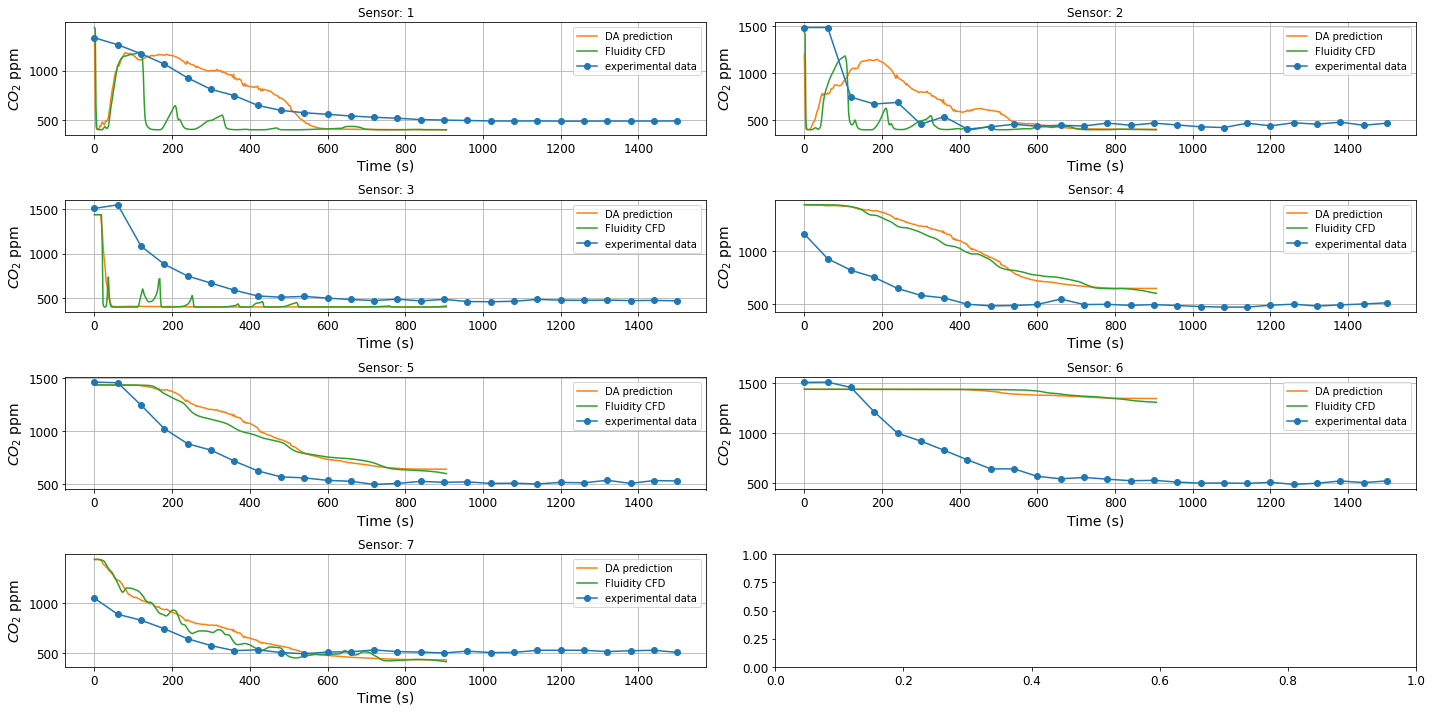

In [ ]:
fig, ax = plt.subplots(4,2, figsize=[20,10])
for i in range(7):
  ax.flatten()[i].set_title('Sensor: {}' .format(i+1))
  ax.flatten()[i].plot(CO2_timevals[0], norm_sensor_CO2_DA[:-1,i], 'C1-')
  ax.flatten()[i].plot(CO2_timevals[0], CO2_sensor_all[:-1,i], 'C2-')
  ax.flatten()[i].plot(CO2_experiment[0], CO2_experiment[i+1, :], 'o-')
  ax.flatten()[i].set_xlabel('Time (s)')
  ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
  ax.flatten()[i].grid()

  ax.flatten()[i].legend(['DA prediction', 'Fluidity CFD', 'experimental data'])
fig.tight_layout()

MSE plots/calculations

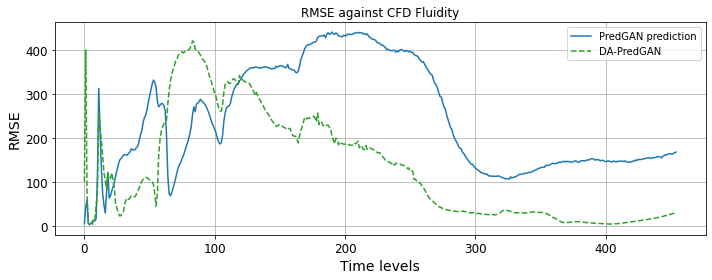

In [ ]:
from sklearn.metrics import mean_squared_error
fig, ax = plt.subplots(1,1, figsize=[10,4])
mse_DA = []
mse_ = []

for i in range(455):
  mse_.append(mean_squared_error(CO2_sensor_all[i], norm_sensor_CO2_[i], squared=False))
  mse_DA.append(mean_squared_error(CO2_sensor_all[i], norm_sensor_CO2_DA[i], squared=False))

ax.plot(mse_, '-')
ax.plot(mse_DA, 'C2--')
ax.legend(['PredGAN prediction', 'DA-PredGAN'])
ax.set_title('RMSE against CFD Fluidity')
ax.set_ylabel('RMSE')
ax.set_xlabel('Time levels')
ax.grid()

fig.tight_layout()
plt.savefig('/content/gdrive/MyDrive/ACSE-9/Scripts_final/Results_figures/RMSE_CFD.pdf', bbox_inches='tight')

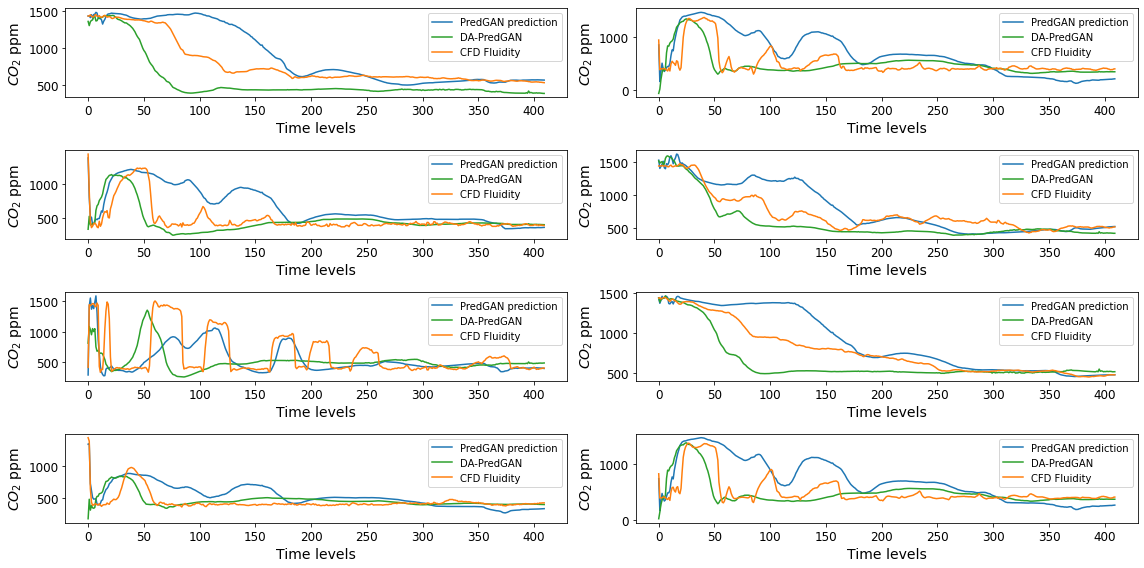

In [ ]:
fig, ax = plt.subplots(4,2, figsize=[16,8])
for i in range(8):
    ax.flatten()[i].plot(norm_co2_[:410, rand_nodes_report[i]], '-')
    ax.flatten()[i].plot(norm_co2_DA[:410, rand_nodes_report[i]], 'C2-')
    ax.flatten()[i].plot(real_co2_[:410, rand_nodes_report[i]], 'C1-')
    ax.flatten()[i].set_xlabel('Time levels')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].legend(['PredGAN prediction', 'DA-PredGAN', 'CFD Fluidity'])

fig.tight_layout()

Test Case: Experimental Data
 - Using experimental observations with DA

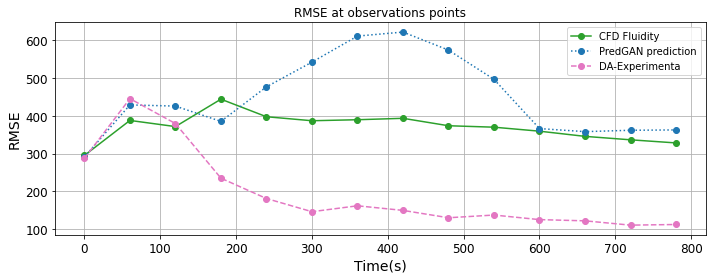

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[10,4])

mse_fluidity_exp = []
mse_DA_exp = []
mse_norm_exp = []

cnt = 1
for i in CO2_experiment[0]:
  if i < 820:
    mse_fluidity_exp.append(mean_squared_error(CO2_experiment[1:,cnt], CO2_sensor_all[int(i/2), :], squared=False))
    mse_norm_exp.append(mean_squared_error(CO2_experiment[1:,cnt], norm_sensor_CO2_[int(i/2), :], squared=False))
    mse_DA_exp.append(mean_squared_error(CO2_experiment[1:,cnt], norm_sensor_CO2_DA_exp[int(i/2), :], squared=False))
    cnt +=1

ax.plot(CO2_experiment[0,:14],mse_fluidity_exp, 'C2o-', label='CFD Fluidity')
ax.plot(CO2_experiment[0,:14],mse_norm_exp, 'o:', label='PredGAN prediction')
ax.plot(CO2_experiment[0,:14],mse_DA_exp, 'C6o--', label='DA-Experimenta')
ax.set_title('RMSE at observations points')
ax.set_ylabel('RMSE')
ax.set_xlabel('Time(s)')
ax.grid()
ax.legend()
fig.tight_layout()

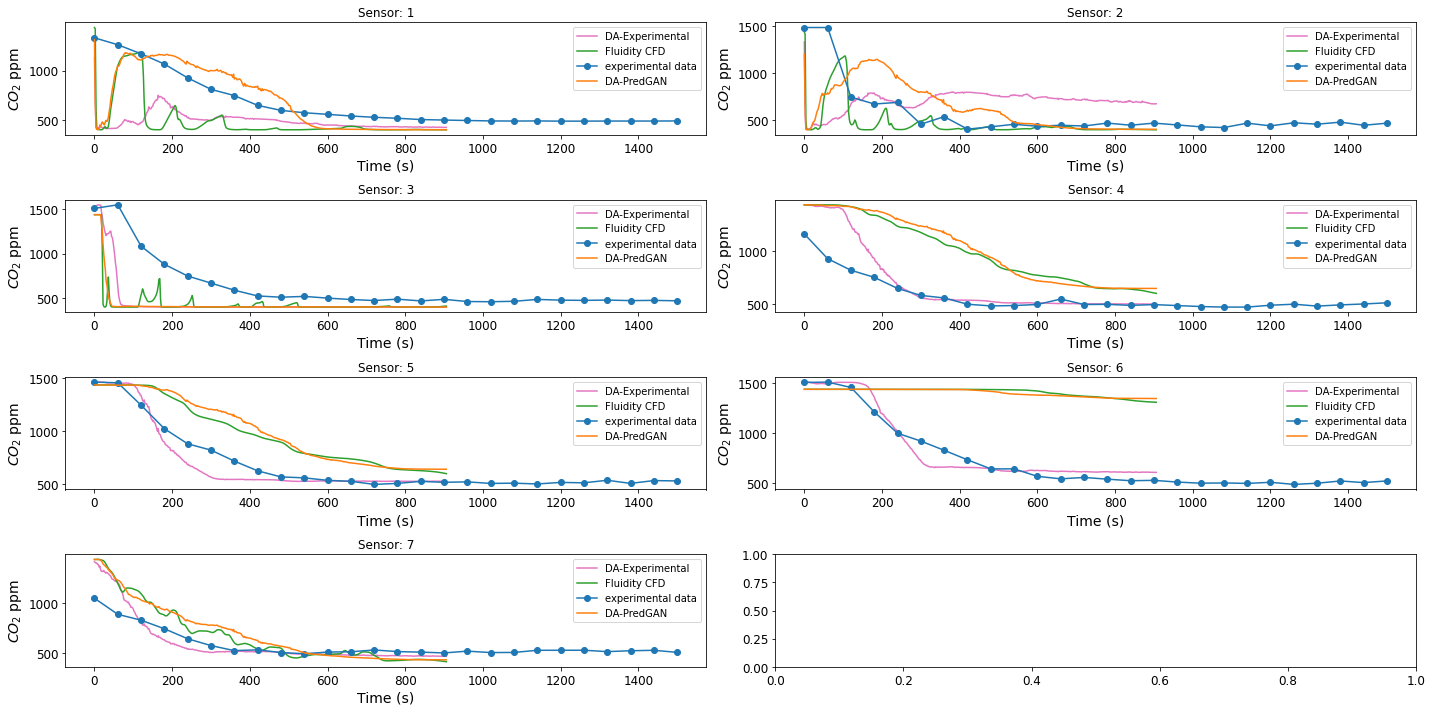

In [ ]:
fig, ax = plt.subplots(4,2, figsize=[20,10])
for i in range(7):
    ax.flatten()[i].set_title('Sensor: {}' .format(i+1))
    ax.flatten()[i].plot(CO2_timevals[0], norm_sensor_CO2_DA_exp[:-1,i], 'C6-')
    ax.flatten()[i].plot(CO2_timevals[0], CO2_sensor_all[:-1,i], 'C2-')
    ax.flatten()[i].plot(CO2_experiment[0], CO2_experiment[i+1, :], 'o-')
    ax.flatten()[i].plot(CO2_timevals[0], norm_sensor_CO2_DA[:-1,i], 'C1-')
    ax.flatten()[i].set_xlabel('Time (s)')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].legend(['DA-Experimental', 'Fluidity CFD', 'experimental data', 'DA-PredGAN'])

fig.tight_layout()

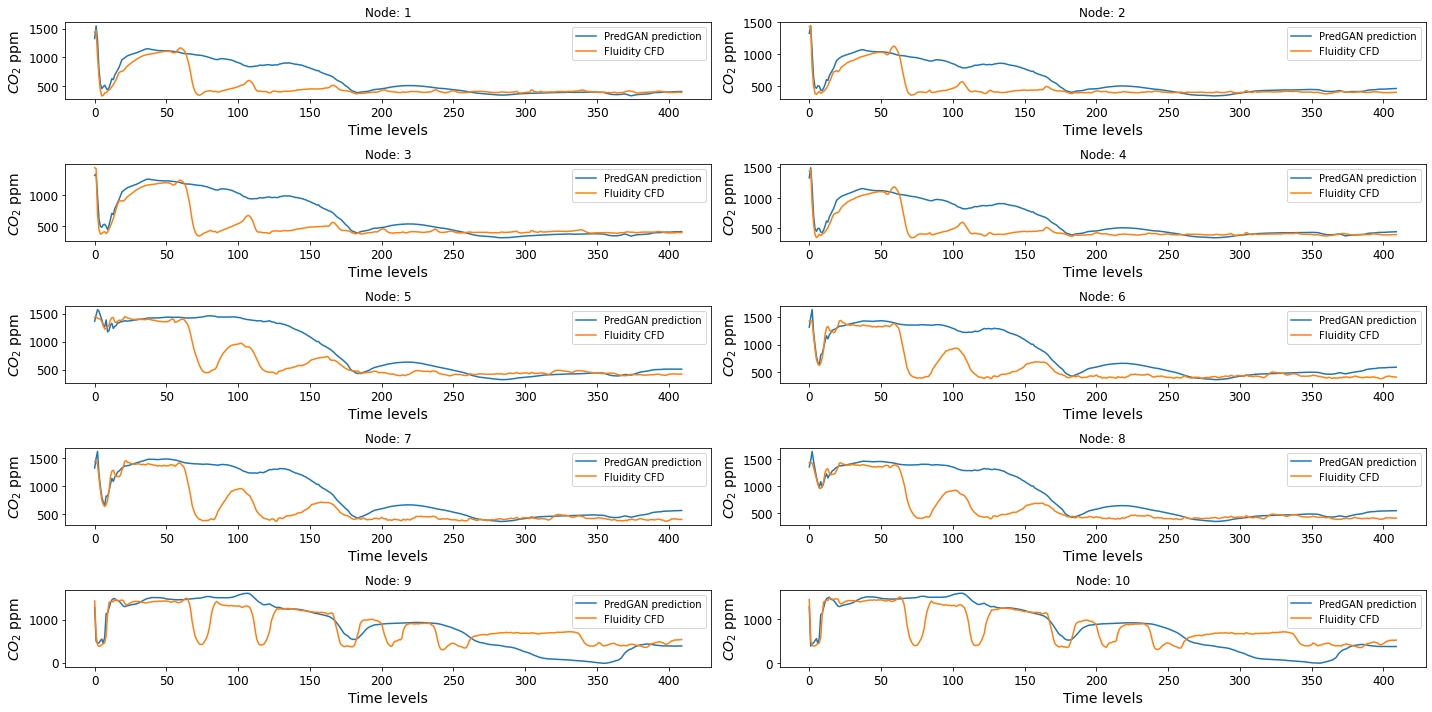

In [ ]:
## Temporal variation of first 10 nodes

fig, ax = plt.subplots(5,2, figsize=[20,10])
for i in range(10):
    ax.flatten()[i].set_title('Node: {}' .format(i+1))
    ax.flatten()[i].plot(norm_co2_[:410,i], '-')
    ax.flatten()[i].plot(real_co2_[:410,i], 'C1-')
    ax.flatten()[i].set_xlabel('Time levels')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].legend(['PredGAN prediction', 'Fluidity CFD'])
    
fig.tight_layout()


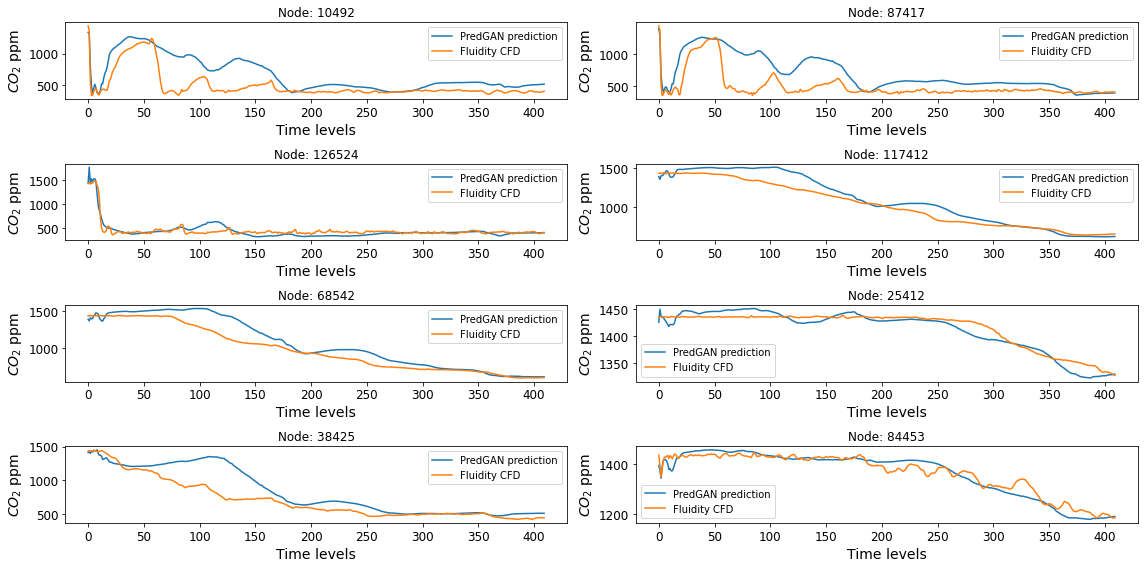

In [ ]:
# peripheral/surrounding nodes of sensor location
locs = [10492, 87417, 126524, 117412, 68542, 25412, 38425, 84453]

fig, ax = plt.subplots(4,2, figsize=[16,8])
for i in range(8):
    ax.flatten()[i].set_title('Node: {}' .format(locs[i]))
    ax.flatten()[i].plot(norm_co2_[:410, locs[i]], '-')
    ax.flatten()[i].plot(real_co2_[:410, locs[i]], 'C1-')
    ax.flatten()[i].set_xlabel('Time levels')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].legend(['PredGAN prediction', 'Fluidity CFD'])
    
fig.tight_layout()
plt.savefig('/content/gdrive/MyDrive/ACSE-9/Scripts_final/Results_figures/PredGAN_peripheralNodes.pdf', bbox_inches='tight')

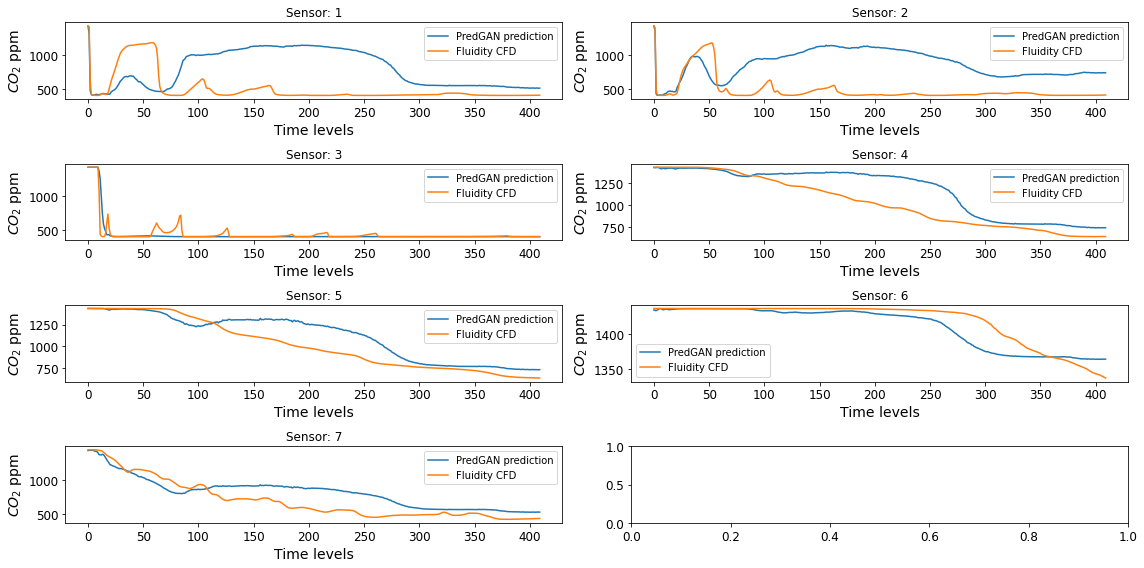

In [ ]:
# Comparison at CO_2 sensor locations

fig, ax = plt.subplots(4,2, figsize=[16, 8])
for i in range(7):
    ax.flatten()[i].set_title('Sensor: {}' .format(i+1))
    ax.flatten()[i].plot(norm_sensor_CO2_[:410, i], '-')
    ax.flatten()[i].plot(CO2_sensor_all[:410, i], 'C1-')
    ax.flatten()[i].set_xlabel('Time levels')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].legend(['PredGAN prediction', 'Fluidity CFD'])
    
fig.tight_layout()


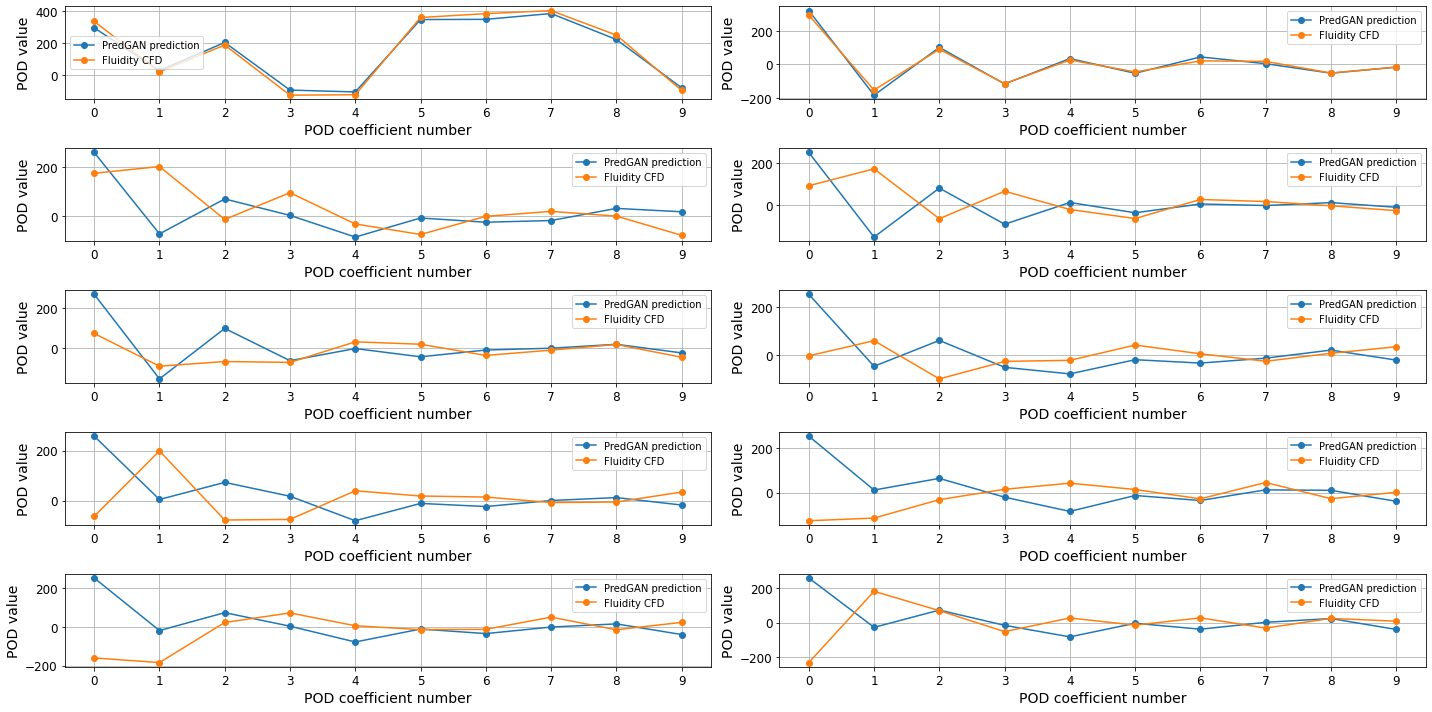

In [ ]:
fig, ax = plt.subplots(5,2, figsize=[20,10])
for i in range(10):
    ax.flatten()[i].plot(alpha_unscaled[40*i, :10], '-o', label='PredGAN prediction')
    ax.flatten()[i].plot(X_train_pca[40*i, :10], 'C1-o', label='Fluidity CFD')
    ax.flatten()[i].legend()
    ax.flatten()[i].set_xlabel('POD coefficient number')
    ax.flatten()[i].set_ylabel('POD value')
    ax.flatten()[i].set_xticks(np.arange(0,10,1))
    ax.flatten()[i].grid()

fig.tight_layout()
# plt.savefig('/content/gdrive/MyDrive/ACSE-9/Scripts_final/Results_figures/PredGAN_PODcoeff_convergence.pdf', bbox_inches='tight')

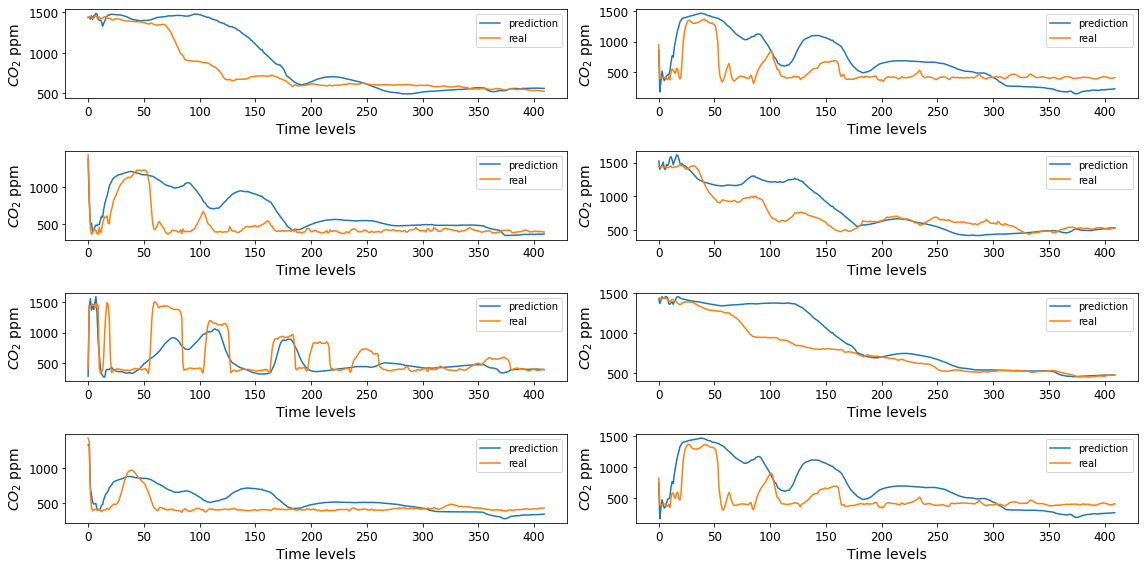

In [ ]:
# 8 random nodes from across the domain
import random
r_nodes = random.sample(range(1, 148906), 8)
r_nodes.sort()

rand_nodes_report = r_nodes.copy()

# explicitly created variable below to ensure reproducibility if validating against report results
rand_nodes_report = [18071, 46784, 86376, 34646, 144594, 102752, 133064, 136683]

fig, ax = plt.subplots(4,2, figsize=[16,8])
for i in range(8):
    ax.flatten()[i].plot(norm_co2_[:410, rand_nodes_report[i]], '-')
    ax.flatten()[i].plot(real_co2_[:410, rand_nodes_report[i]], '-')
    ax.flatten()[i].set_xlabel('Time levels')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].legend(['prediction', 'real'])

fig.tight_layout()

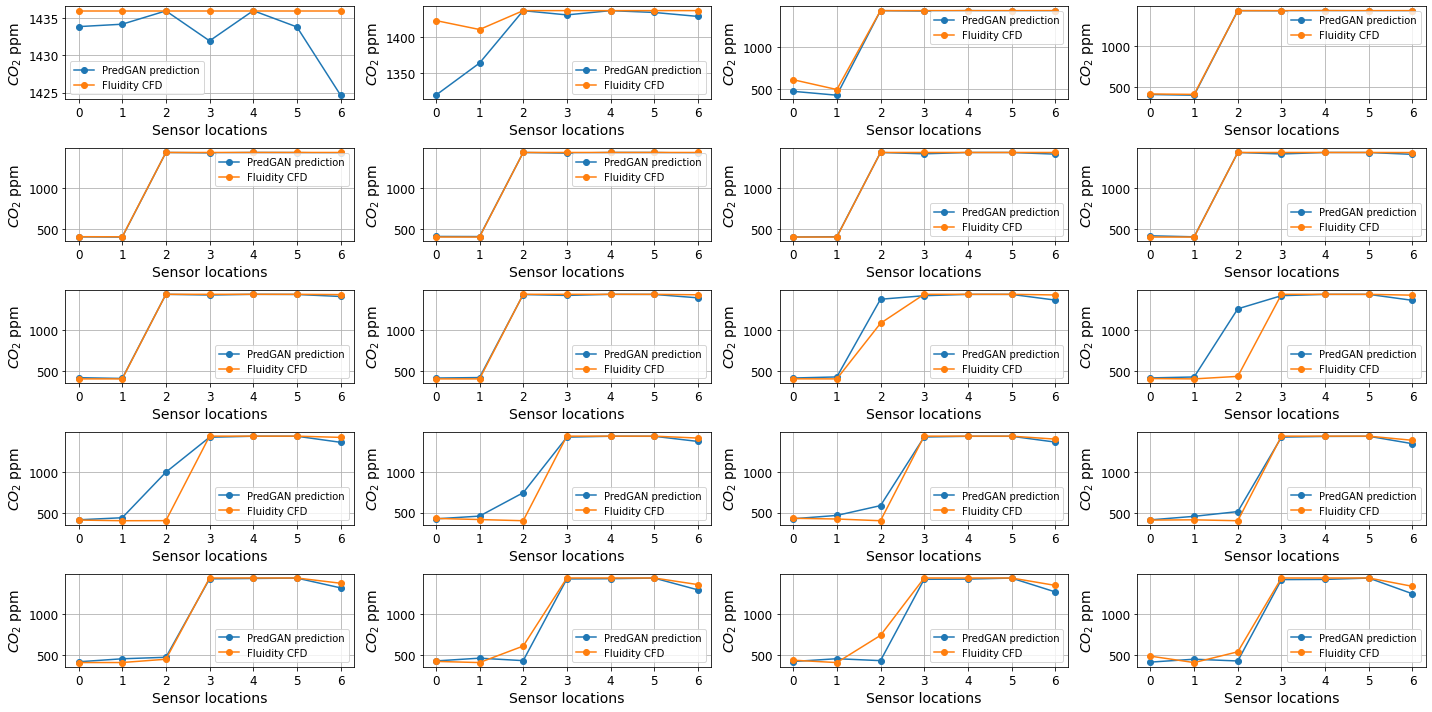

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[i, :], '-o', label='PredGAN prediction')
    ax.flatten()[i].plot(CO2_sensor_all[i, :], 'C1-o', label='Fluidity CFD')
    ax.flatten()[i].legend()
    ax.flatten()[i].set_xlabel('Sensor locations')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].grid()

fig.tight_layout()

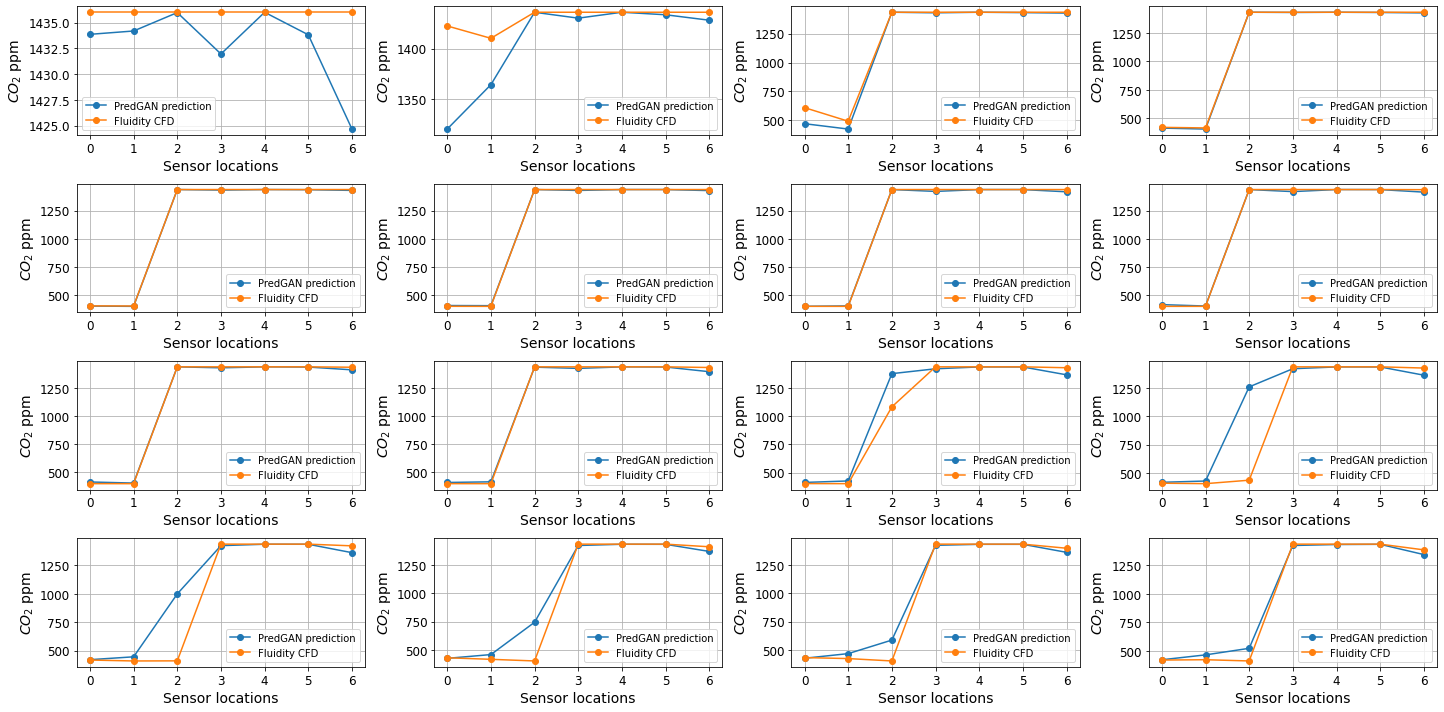

In [ ]:
#First 16
fig, ax = plt.subplots(4,4, figsize=[20,10])
for i in range(16):
    ax.flatten()[i].plot(norm_sensor_CO2_[i, :], '-o', label='PredGAN prediction')
    ax.flatten()[i].plot(CO2_sensor_all[i, :], 'C1-o', label='Fluidity CFD')
    ax.flatten()[i].legend()
    ax.flatten()[i].set_xlabel('Sensor locations')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].grid()

fig.tight_layout()

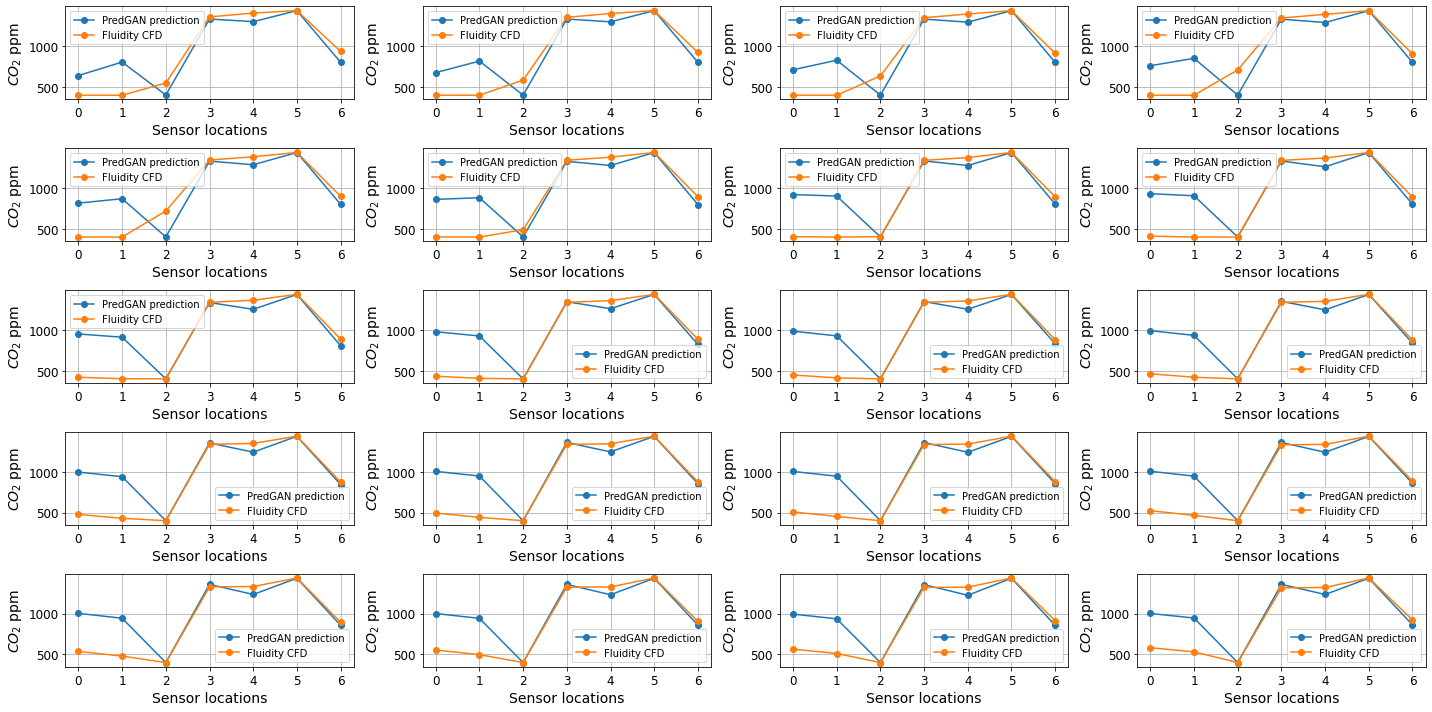

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[80+i, :], '-o', label='PredGAN prediction')
    ax.flatten()[i].plot(CO2_sensor_all[80+i, :], 'C1-o', label='Fluidity CFD')
    ax.flatten()[i].legend()
    ax.flatten()[i].set_xlabel('Sensor locations')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].grid()

fig.tight_layout()

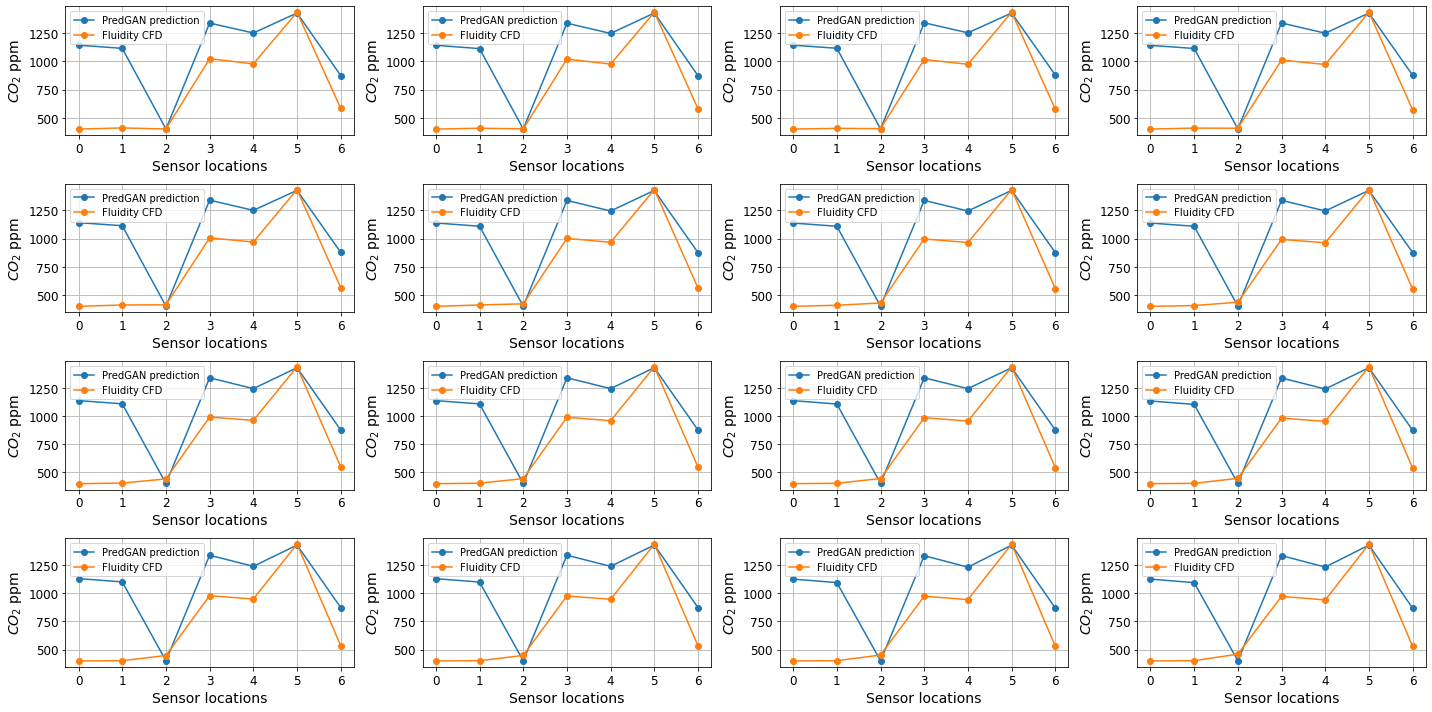

In [ ]:
fig, ax = plt.subplots(4,4, figsize=[20,10])
for i in range(16):
    ax.flatten()[i].plot(norm_sensor_CO2_[200+i, :], '-o', label='PredGAN prediction')
    ax.flatten()[i].plot(CO2_sensor_all[200+i, :], 'C1-o', label='Fluidity CFD')
    ax.flatten()[i].legend()
    ax.flatten()[i].set_xlabel('Sensor locations')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].grid()

fig.tight_layout()

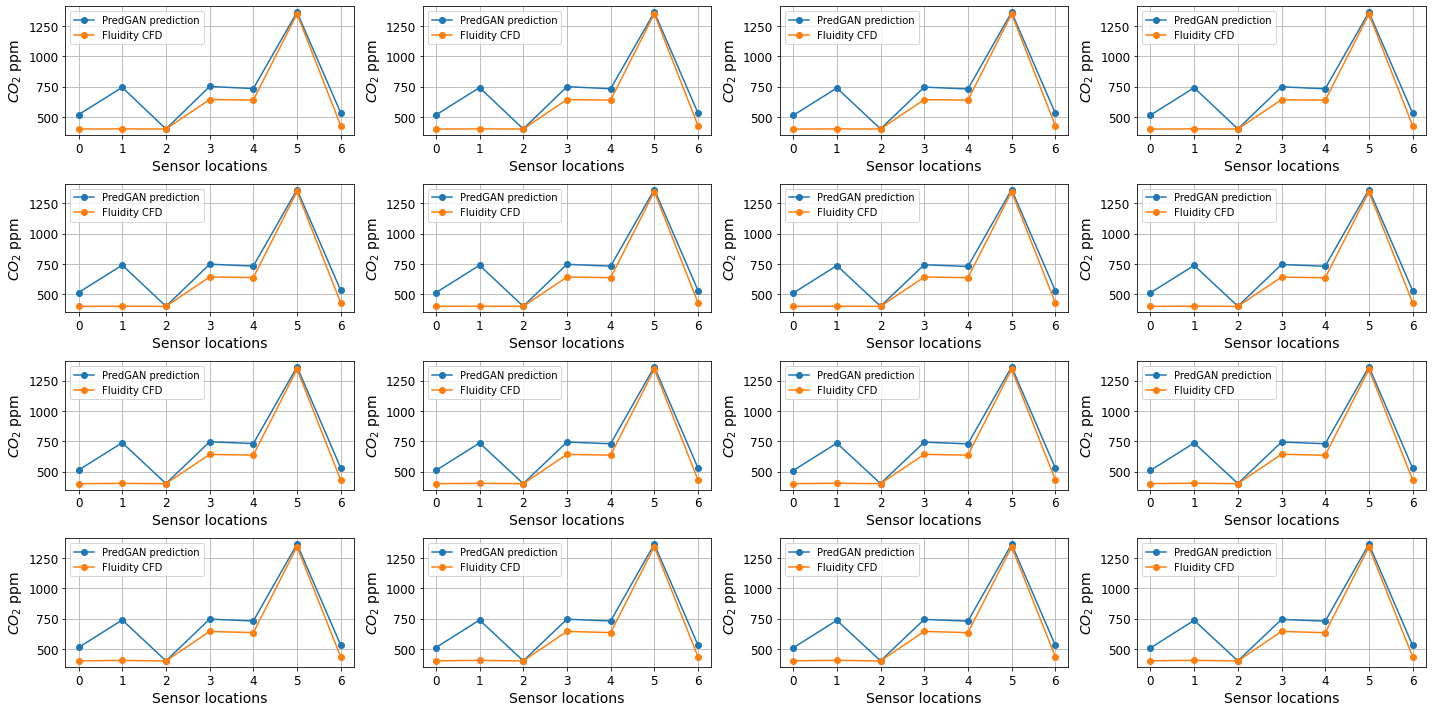

In [ ]:
fig, ax = plt.subplots(4,4, figsize=[20,10])
for i in range(16):
    ax.flatten()[i].plot(norm_sensor_CO2_[390+i, :], '-o', label='PredGAN prediction')
    ax.flatten()[i].plot(CO2_sensor_all[390+i, :], 'C1-o', label='Fluidity CFD')
    ax.flatten()[i].legend()
    ax.flatten()[i].set_xlabel('Sensor locations')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].grid()

fig.tight_layout()

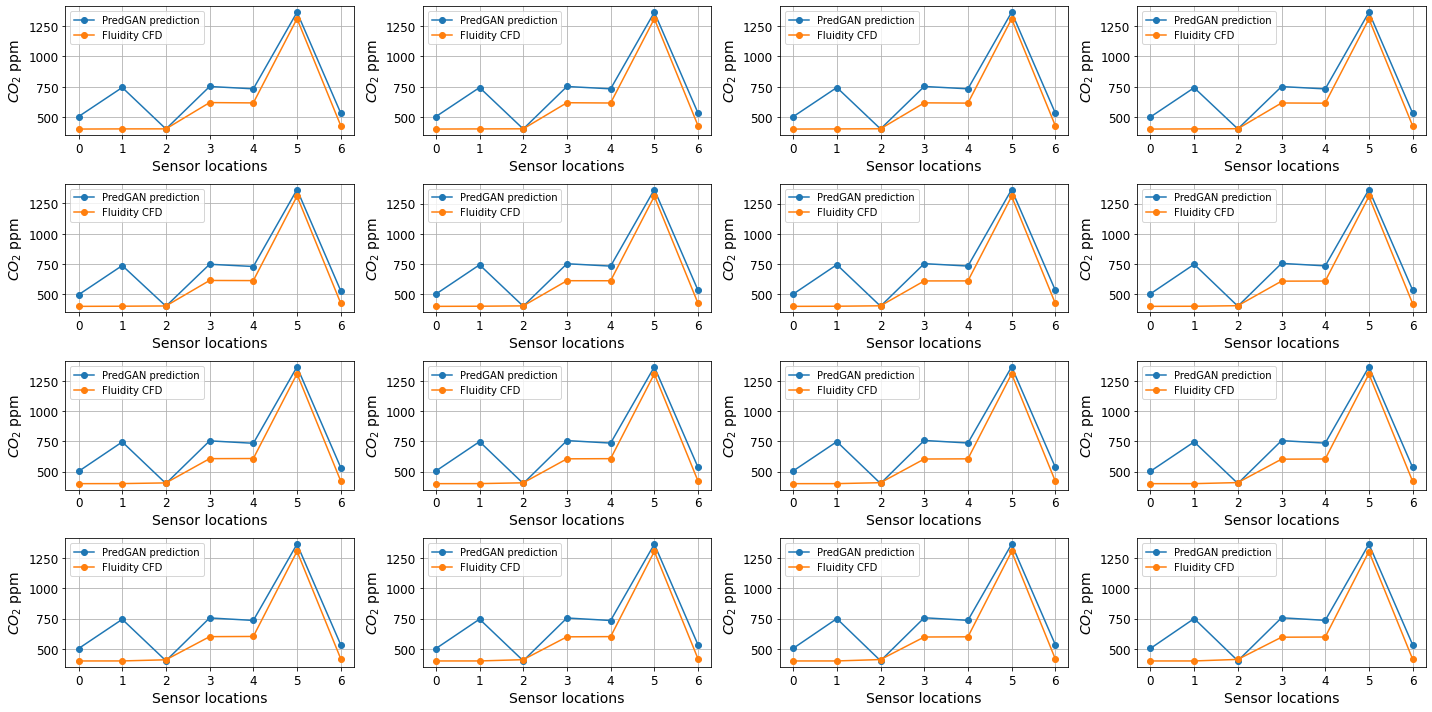

In [ ]:
fig, ax = plt.subplots(4,4, figsize=[20,10])
for i in range(16):
    ax.flatten()[i].plot(norm_sensor_CO2_[439+i, :], '-o', label='PredGAN prediction')
    ax.flatten()[i].plot(CO2_sensor_all[439+i, :], 'C1-o', label='Fluidity CFD')
    ax.flatten()[i].legend()
    ax.flatten()[i].set_xlabel('Sensor locations')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].grid()

fig.tight_layout()

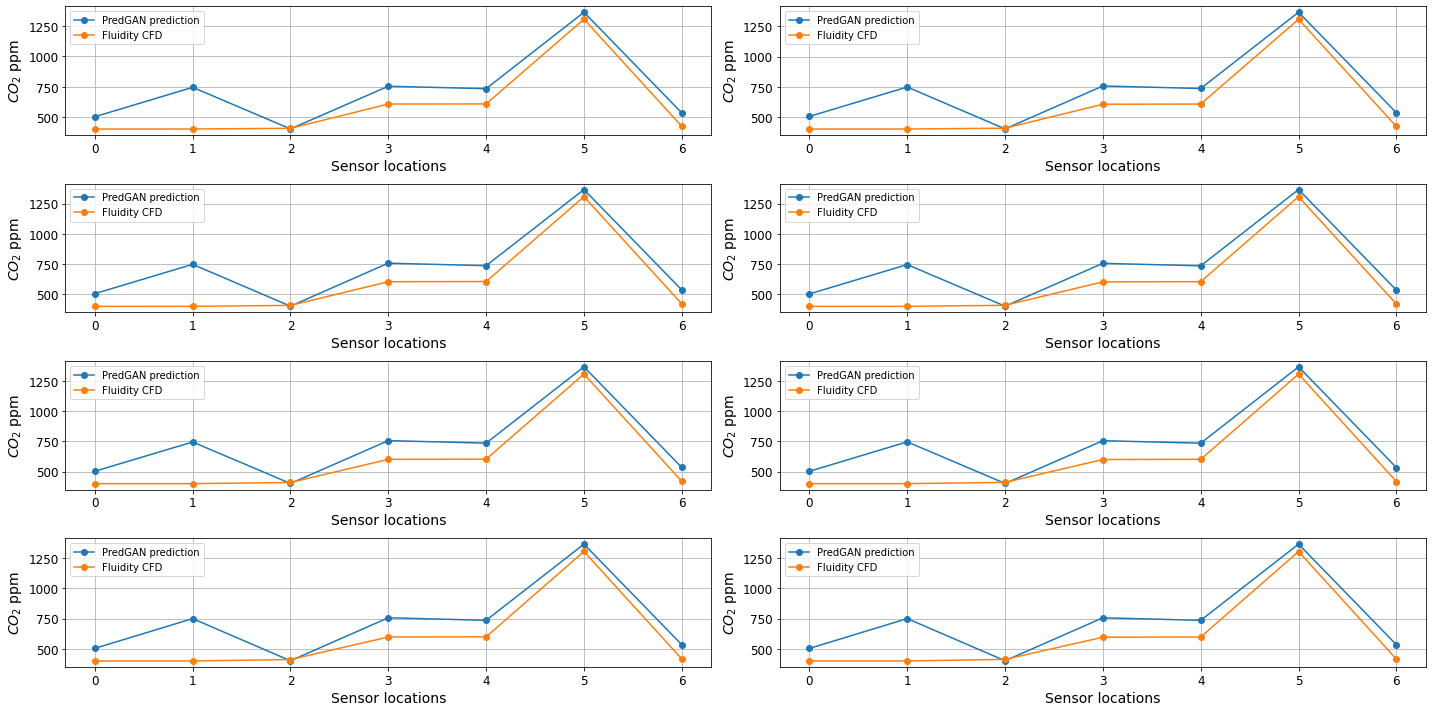

In [ ]:
fig, ax = plt.subplots(4,2, figsize=[20,10])
for i in range(8):
    ax.flatten()[i].plot(norm_sensor_CO2_[447+i, :], '-o', label='PredGAN prediction')
    ax.flatten()[i].plot(CO2_sensor_all[447+i, :], 'C1-o', label='Fluidity CFD')
    ax.flatten()[i].legend()
    ax.flatten()[i].set_xlabel('Sensor locations')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].grid()

fig.tight_layout()
# plt.savefig('/content/gdrive/MyDrive/ACSE-9/Scripts_final/Results_figures/PredGAN_477_455_SensorLocs.pdf', bbox_inches='tight')

### DA-PredGAN Results

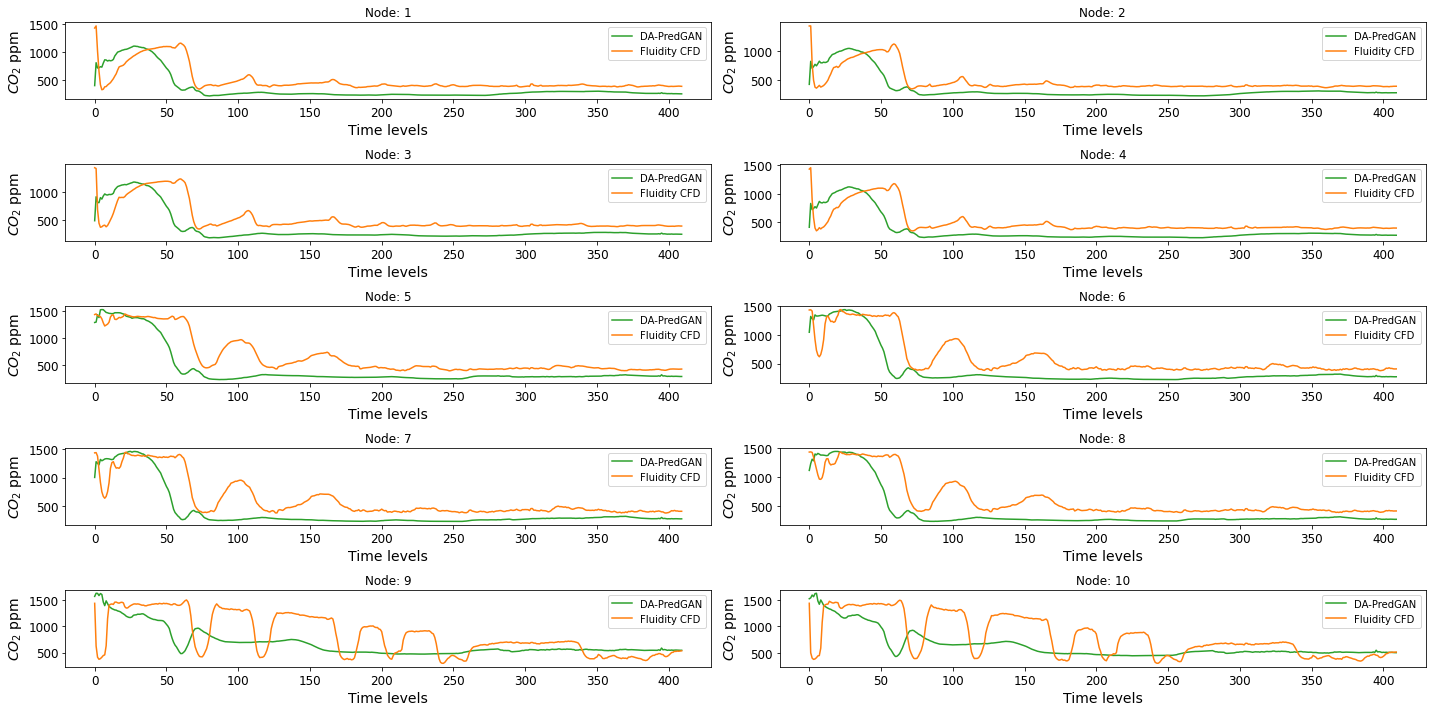

In [ ]:
## variation across first 10 nodes

fig, ax = plt.subplots(5,2, figsize=[20,10])
for i in range(10):
    ax.flatten()[i].set_title('Node: {}' .format(i+1))
    ax.flatten()[i].plot(norm_co2_DA[:410,i], 'C2-')
    ax.flatten()[i].plot(real_co2_[:410,i], 'C1-')
    ax.flatten()[i].set_xlabel('Time levels')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].legend(['DA-PredGAN', 'Fluidity CFD'])
    
fig.tight_layout()


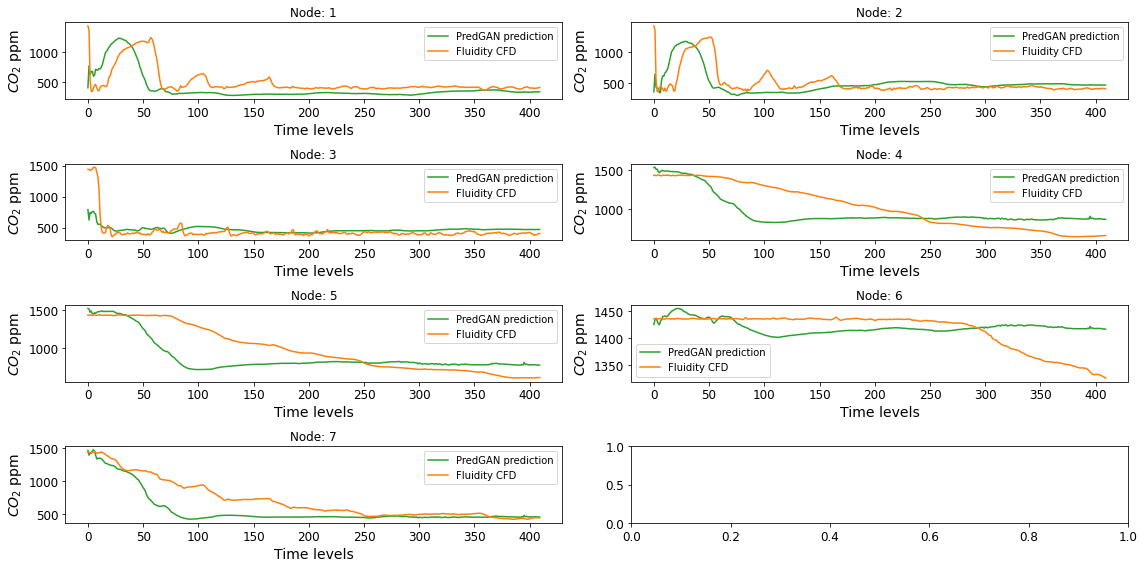

In [ ]:
# peripheral/surrounding nodes of sensor location
locs = [10492, 87417, 126524, 117412, 68542, 25412, 38425, 84453]

fig, ax = plt.subplots(4,2, figsize=[16,8])
for i in range(7):
    ax.flatten()[i].set_title('Node: {}' .format(i+1))
    ax.flatten()[i].plot(norm_co2_DA[:410, locs[i]], 'C2-')
    ax.flatten()[i].plot(real_co2_[:410, locs[i]], 'C1-')
    ax.flatten()[i].set_xlabel('Time levels')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].legend(['PredGAN prediction', 'Fluidity CFD'])
    
fig.tight_layout()


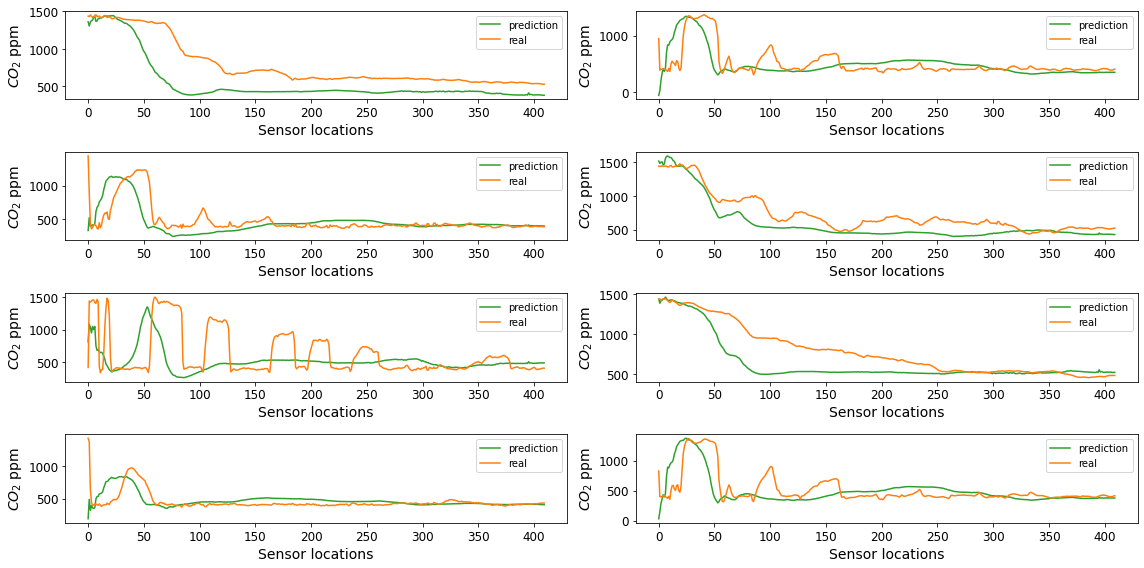

In [ ]:
# 8 random nodes from across the domain
import random
r_nodes = random.sample(range(1, 148906), 10)
r_nodes.sort()

rand_nodes_report = r_nodes.copy()

# explicitly created variable below to ensure reproducibility if validating against report results
rand_nodes_report = [18071, 46784, 86376, 34646, 144594, 102752, 133064, 136683]

fig, ax = plt.subplots(4,2, figsize=[16,8])
for i in range(8):
    ax.flatten()[i].plot(norm_co2_DA[:410, rand_nodes_report[i]], 'C2-')
    ax.flatten()[i].plot(real_co2_[:410, rand_nodes_report[i]], 'C1-')
    ax.flatten()[i].set_xlabel('Sensor locations')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].legend(['prediction', 'real'])

fig.tight_layout()


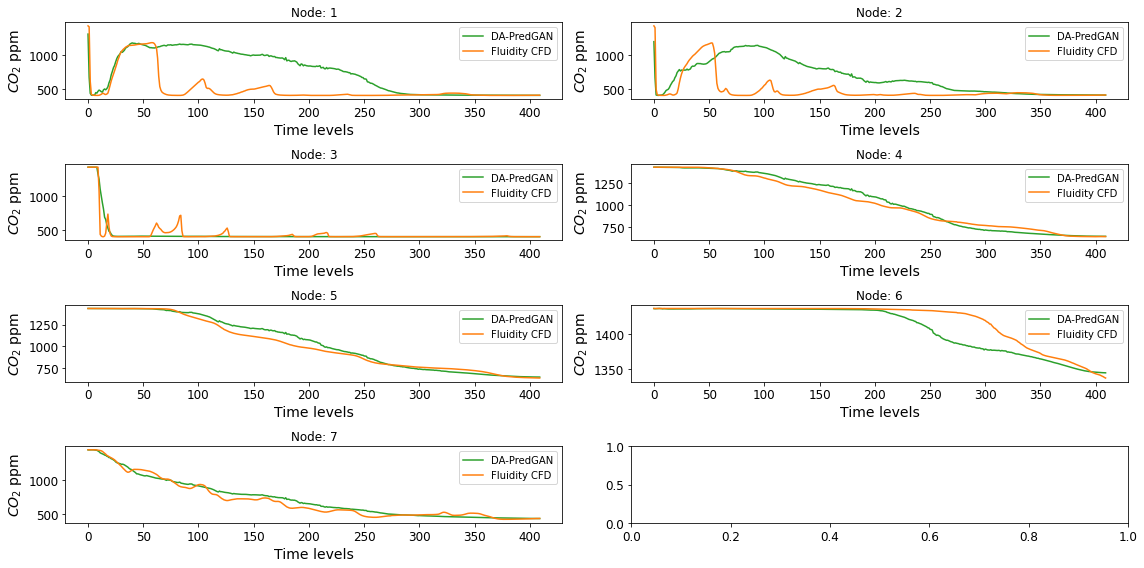

In [ ]:
# Comparison at CO_2 sensor locations

fig, ax = plt.subplots(4,2, figsize=[16, 8])
for i in range(7):
    ax.flatten()[i].set_title('Node: {}' .format(i+1))
    ax.flatten()[i].plot(norm_sensor_CO2_DA[:410, i], 'C2-')
    ax.flatten()[i].plot(CO2_sensor_all[:410, i], 'C1-')
    ax.flatten()[i].set_xlabel('Time levels')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].legend(['DA-PredGAN', 'Fluidity CFD'])
    
fig.tight_layout()


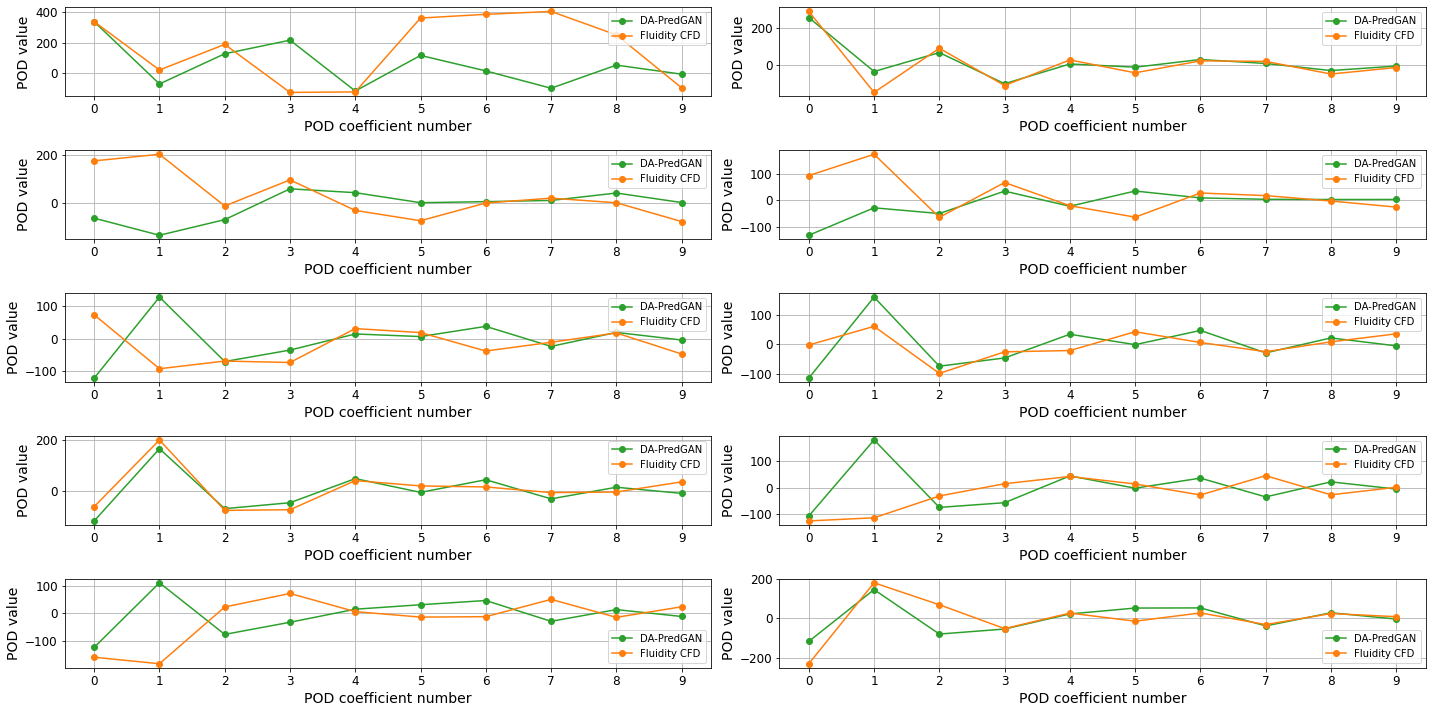

In [ ]:
fig, ax = plt.subplots(5,2, figsize=[20,10])
for i in range(10):
    ax.flatten()[i].plot(alpha_unscaled_DA[40*i, :10], 'C2-o', label='DA-PredGAN')
    ax.flatten()[i].plot(X_train_pca[40*i, :10], 'C1-o', label='Fluidity CFD')
    ax.flatten()[i].legend()
    ax.flatten()[i].set_xlabel('POD coefficient number')
    ax.flatten()[i].set_ylabel('POD value')
    ax.flatten()[i].set_xticks(np.arange(0,10,1))
    ax.flatten()[i].grid()

fig.tight_layout()


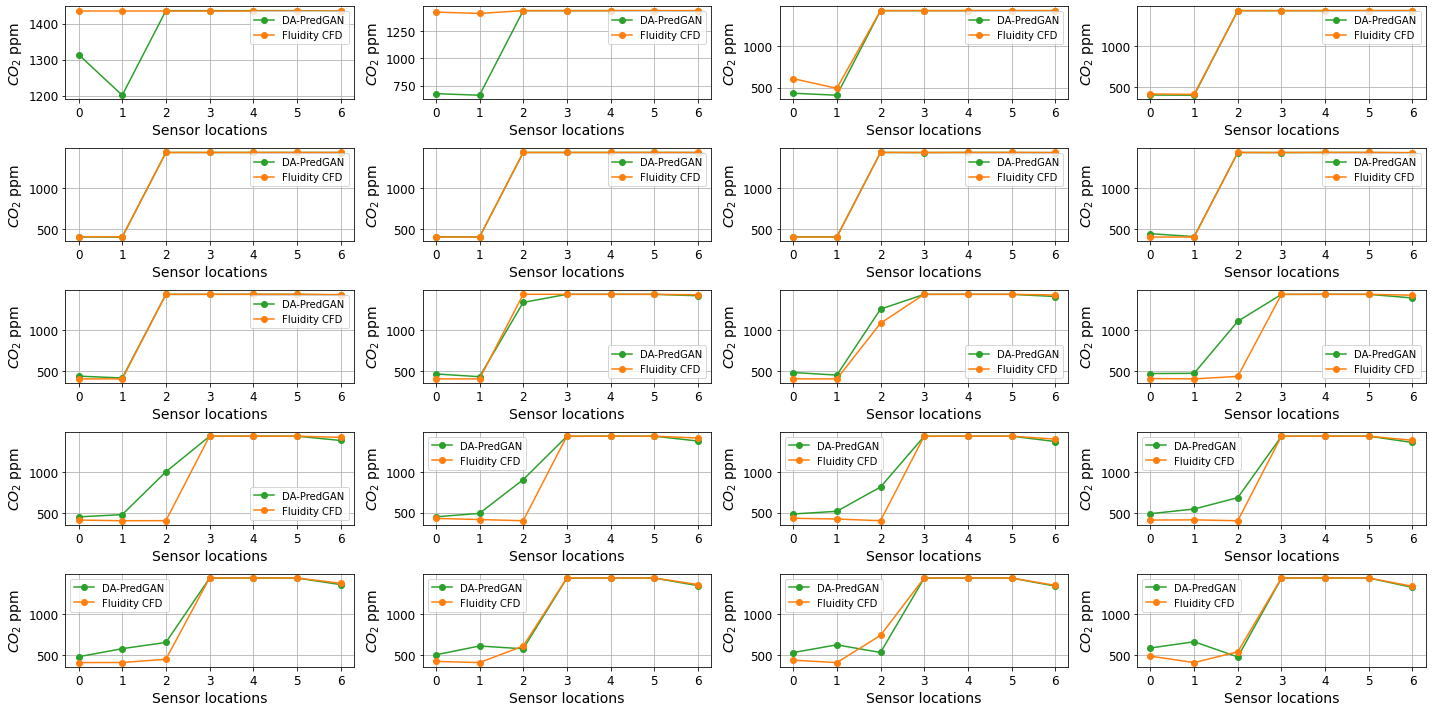

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_DA[i, :], 'C2-o', label='DA-PredGAN')
    ax.flatten()[i].plot(CO2_sensor_all[i, :], 'C1-o', label='Fluidity CFD')
    ax.flatten()[i].legend()
    ax.flatten()[i].set_xlabel('Sensor locations')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].grid()

fig.tight_layout()

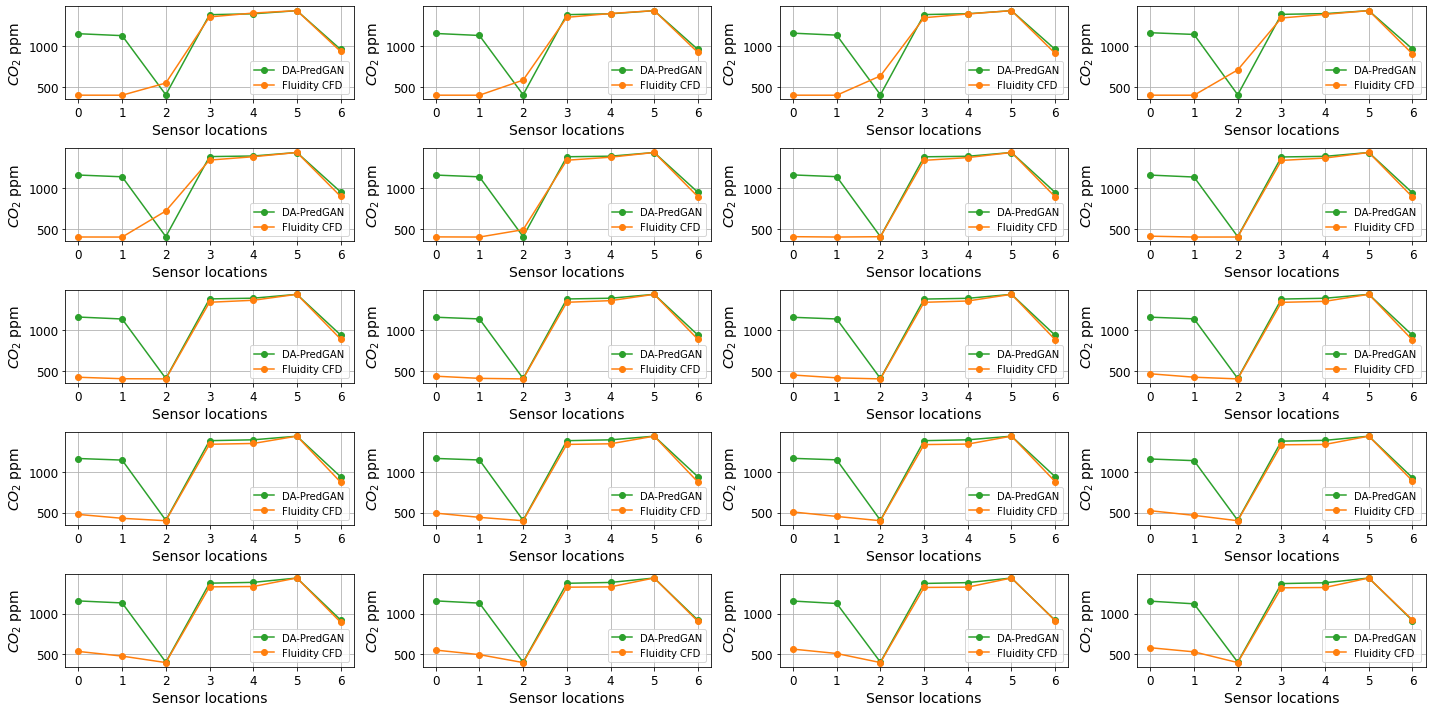

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_DA[80+i, :], 'C2-o', label='DA-PredGAN')
    ax.flatten()[i].plot(CO2_sensor_all[80+i, :], 'C1-o', label='Fluidity CFD')
    ax.flatten()[i].legend()
    ax.flatten()[i].set_xlabel('Sensor locations')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].grid()

fig.tight_layout()

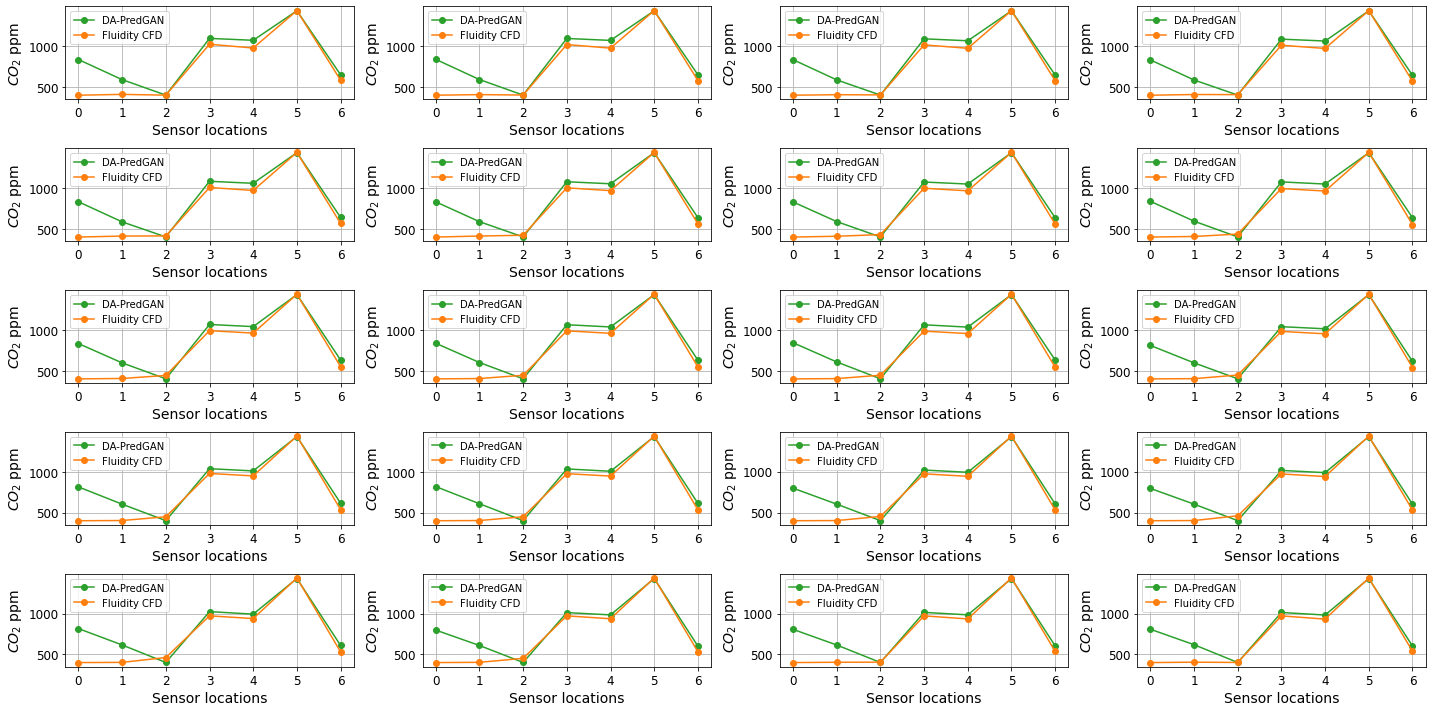

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_DA[200+i, :], 'C2-o', label='DA-PredGAN')
    ax.flatten()[i].plot(CO2_sensor_all[200+i, :], 'C1-o', label='Fluidity CFD')
    ax.flatten()[i].legend()
    ax.flatten()[i].set_xlabel('Sensor locations')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].grid()

fig.tight_layout()

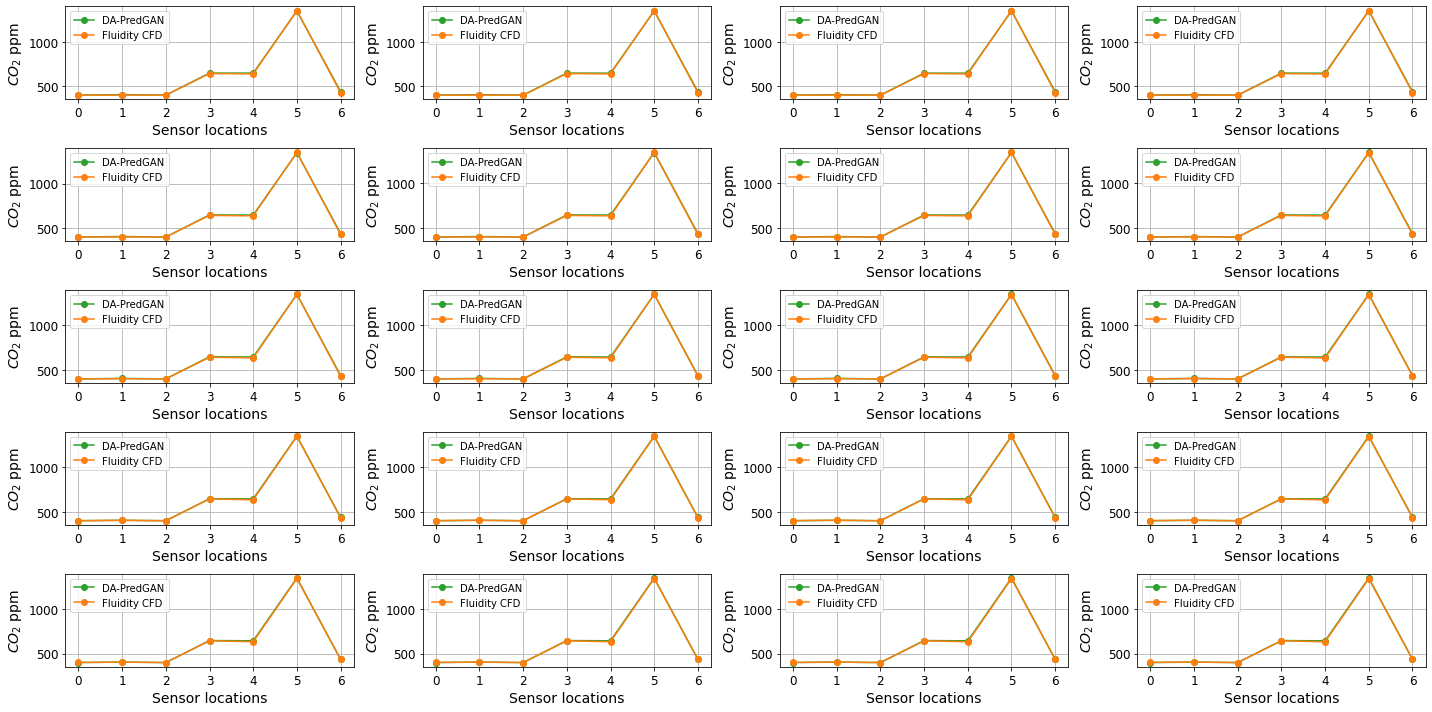

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_DA[390+i, :], 'C2-o', label='DA-PredGAN')
    ax.flatten()[i].plot(CO2_sensor_all[390+i, :], 'C1-o', label='Fluidity CFD')
    ax.flatten()[i].legend()
    ax.flatten()[i].set_xlabel('Sensor locations')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].grid()

fig.tight_layout()

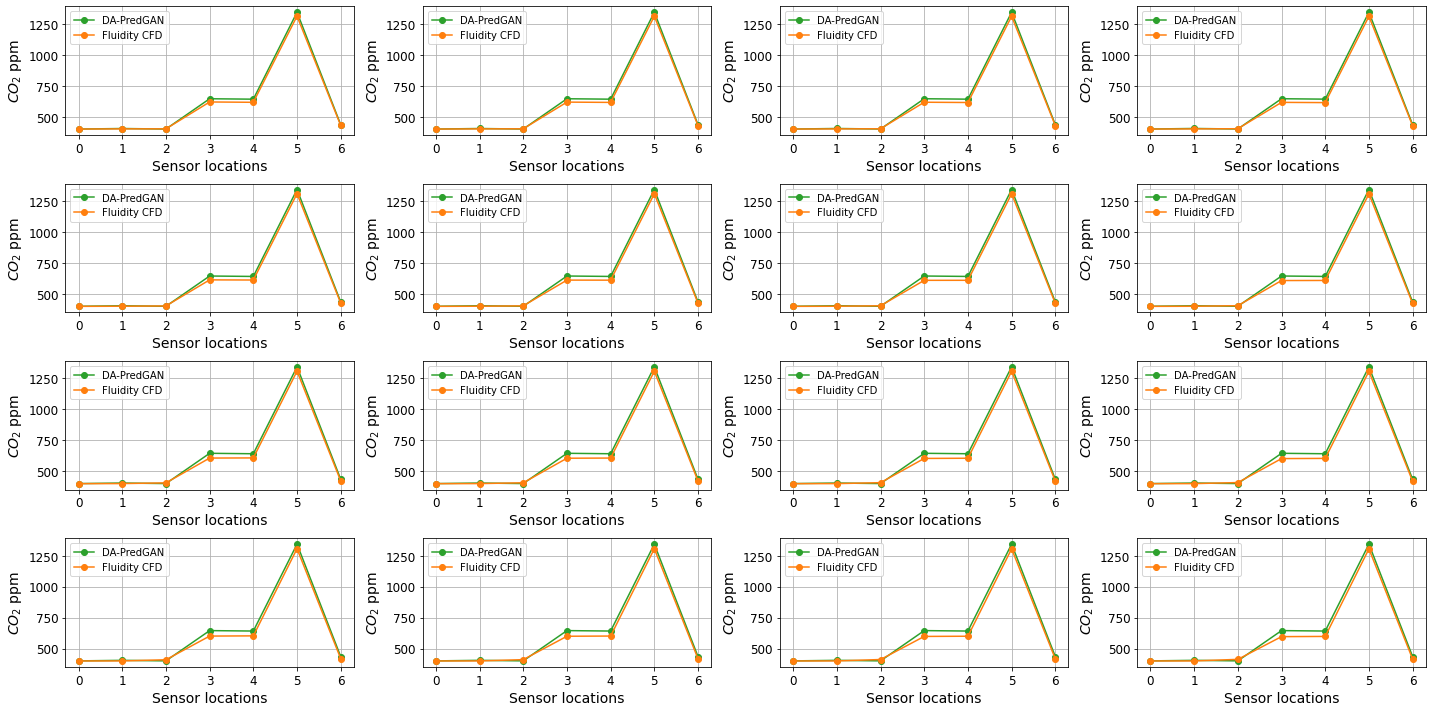

In [ ]:
fig, ax = plt.subplots(4,4, figsize=[20,10])
for i in range(16):
    ax.flatten()[i].plot(norm_sensor_CO2_DA[439+i, :], 'C2-o', label='DA-PredGAN')
    ax.flatten()[i].plot(CO2_sensor_all[439+i, :], 'C1-o', label='Fluidity CFD')
    ax.flatten()[i].legend()
    ax.flatten()[i].set_xlabel('Sensor locations')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].grid()

fig.tight_layout()

Comparing PredGAN, DA-PredGAN, Fluidity CFD

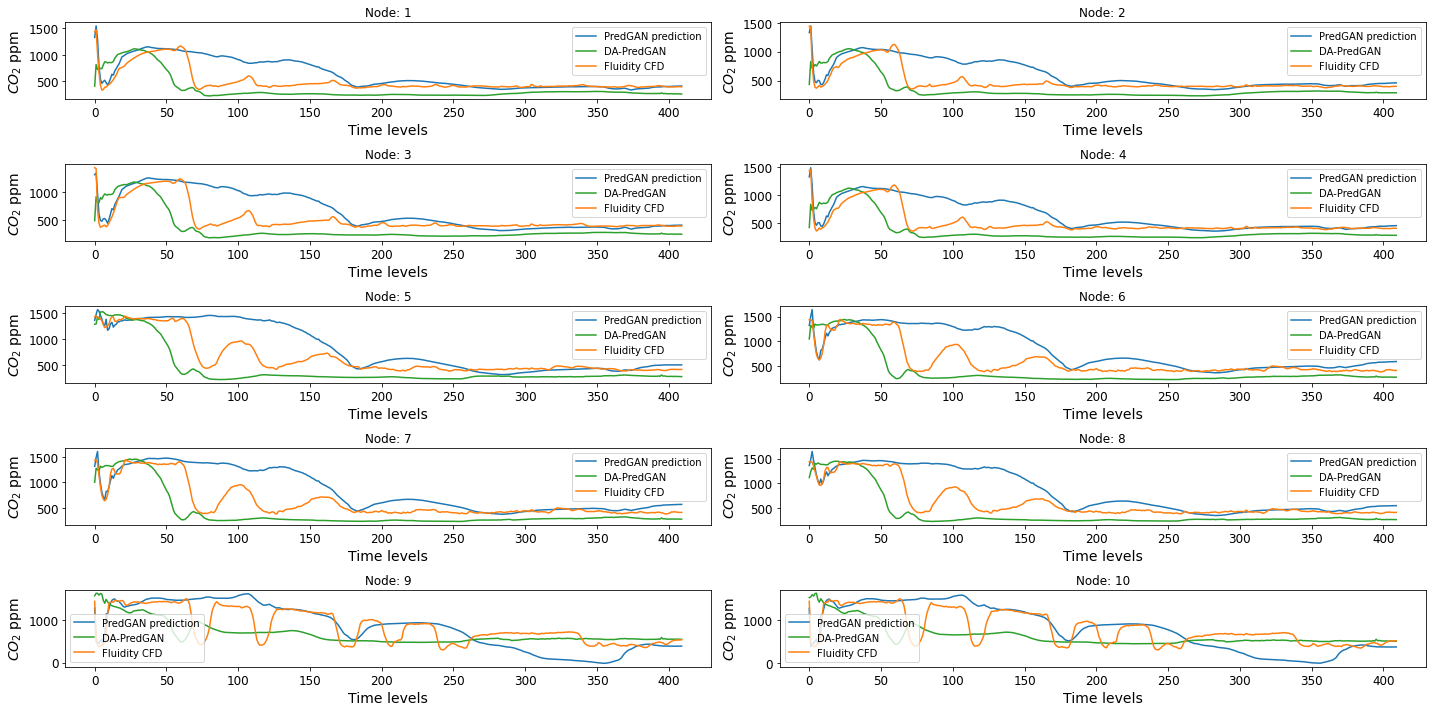

In [ ]:
## Temporal variation of first 10 nodes

fig, ax = plt.subplots(5,2, figsize=[20,10])
for i in range(10):
    ax.flatten()[i].set_title('Node: {}' .format(i+1))
    ax.flatten()[i].plot(norm_co2_[:410,i], '-')
    ax.flatten()[i].plot(norm_co2_DA[:410,i], 'C2-')
    ax.flatten()[i].plot(real_co2_[:410,i], 'C1-')
    ax.flatten()[i].set_xlabel('Time levels')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].legend(['PredGAN prediction', 'DA-PredGAN', 'Fluidity CFD'])
    
fig.tight_layout()


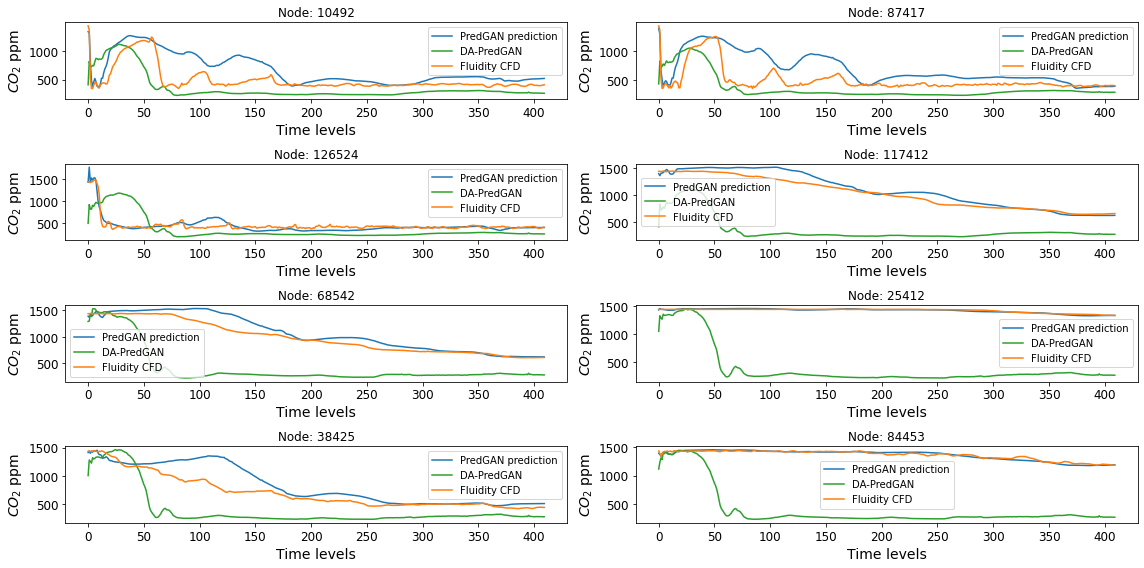

In [ ]:
# peripheral/surrounding nodes of sensor location
locs = [10492, 87417, 126524, 117412, 68542, 25412, 38425, 84453]

fig, ax = plt.subplots(4,2, figsize=[16,8])
for i in range(8):
    ax.flatten()[i].set_title('Node: {}' .format(locs[i]))
    ax.flatten()[i].plot(norm_co2_[:410, locs[i]], '-')
    ax.flatten()[i].plot(norm_co2_DA[:410,i], 'C2-')
    ax.flatten()[i].plot(real_co2_[:410, locs[i]], 'C1-')
    ax.flatten()[i].set_xlabel('Time levels')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].legend(['PredGAN prediction', 'DA-PredGAN', 'Fluidity CFD'])
    
fig.tight_layout()


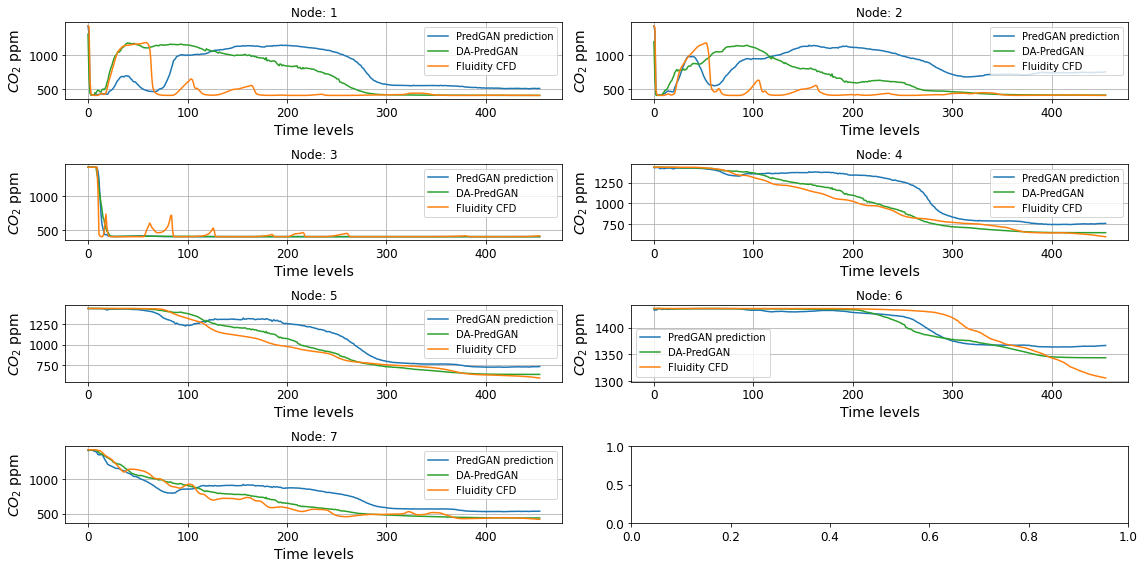

In [ ]:
# Comparison at CO_2 sensor locations

fig, ax = plt.subplots(4,2, figsize=[16, 8])
for i in range(7):
    ax.flatten()[i].set_title('Node: {}' .format(i+1))
    ax.flatten()[i].plot(norm_sensor_CO2_[:, i], '-')
    ax.flatten()[i].plot(norm_sensor_CO2_DA[:, i], 'C2-')
    ax.flatten()[i].plot(CO2_sensor_all[:, i], 'C1-')
    ax.flatten()[i].set_xlabel('Time levels')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].legend(['PredGAN prediction', 'DA-PredGAN', 'Fluidity CFD'])
    ax.flatten()[i].grid()
fig.tight_layout()


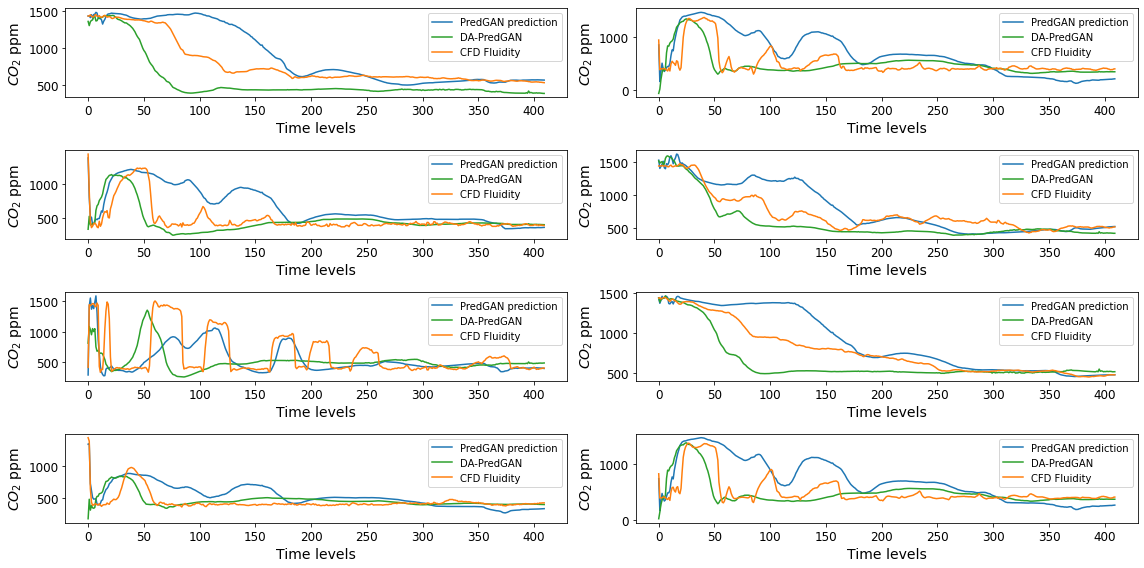

In [ ]:
# 8 random nodes from across the domain
import random
r_nodes = random.sample(range(1, 148906), 10)
r_nodes.sort()

rand_nodes_report = r_nodes.copy()

# explicitly created variable below to ensure reproducibility if validating against report results
rand_nodes_report = [18071, 46784, 86376, 34646, 144594, 102752, 133064, 136683]

fig, ax = plt.subplots(4,2, figsize=[16,8])
for i in range(8):
    ax.flatten()[i].plot(norm_co2_[:410, rand_nodes_report[i]], '-')
    ax.flatten()[i].plot(norm_co2_DA[:410, rand_nodes_report[i]], 'C2-')
    ax.flatten()[i].plot(real_co2_[:410, rand_nodes_report[i]], 'C1-')
    ax.flatten()[i].set_xlabel('Time levels')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].legend(['PredGAN prediction', 'DA-PredGAN', 'CFD Fluidity'])

fig.tight_layout()
# plt.savefig('/content/gdrive/MyDrive/ACSE-9/Scripts_final/Results_figures/Comparison_randomNodes.pdf', bbox_inches='tight')

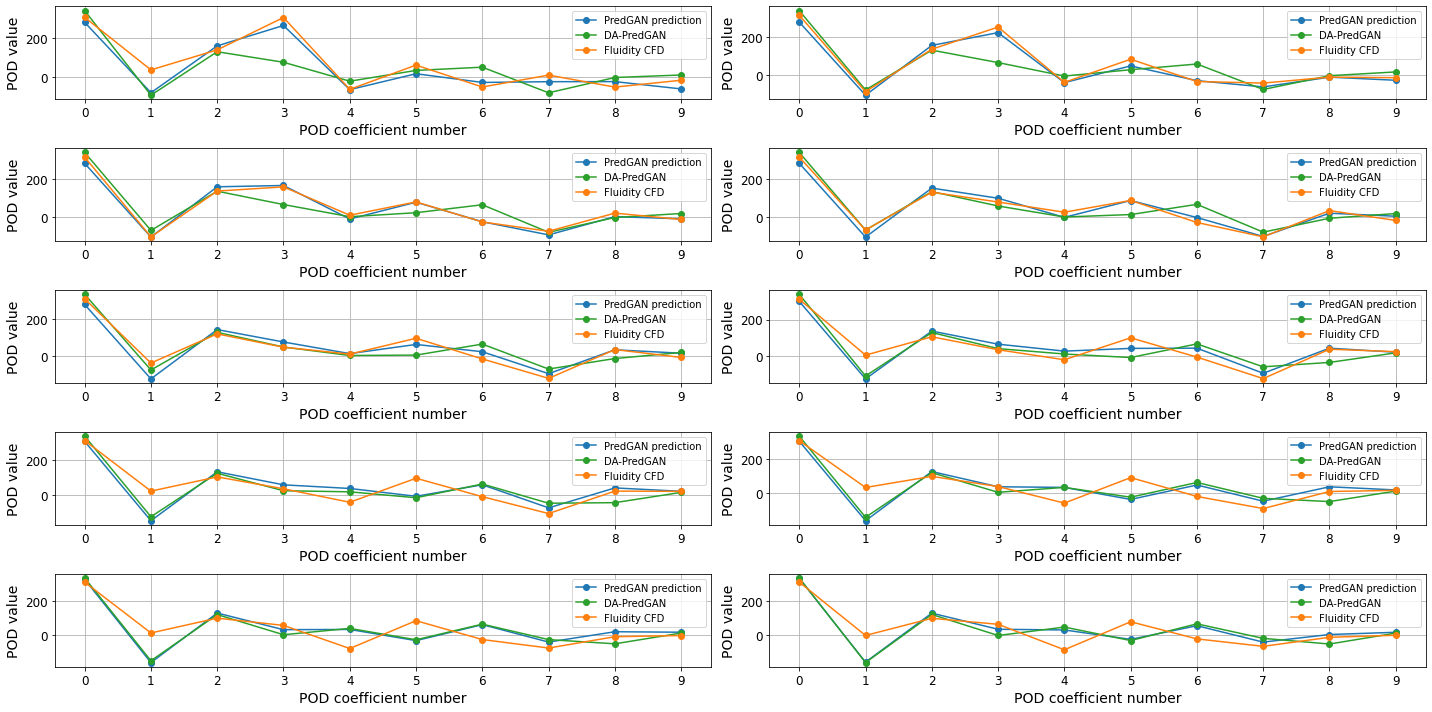

In [ ]:
fig, ax = plt.subplots(5,2, figsize=[20,10])
for i in range(10):
    ax.flatten()[i].plot(alpha_unscaled[i+9, :10], '-o', label='PredGAN prediction')
    ax.flatten()[i].plot(alpha_unscaled_DA[i+9, :10], 'C2-o', label='DA-PredGAN')
    ax.flatten()[i].plot(X_train_pca[i+9, :10], 'C1-o', label='Fluidity CFD')
    ax.flatten()[i].legend()
    ax.flatten()[i].set_xlabel('POD coefficient number')
    ax.flatten()[i].set_ylabel('POD value')
    ax.flatten()[i].set_xticks(np.arange(0,10,1))
    ax.flatten()[i].grid()

fig.tight_layout()


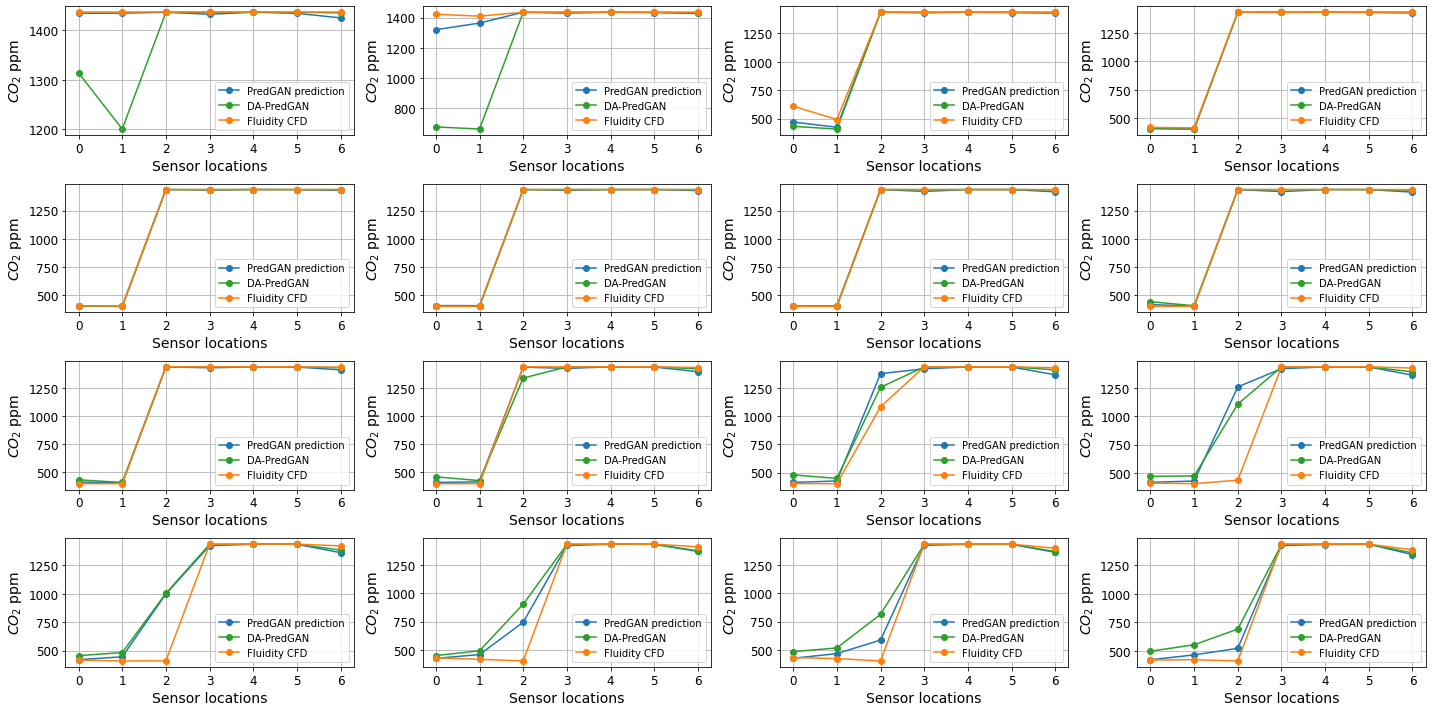

In [ ]:
fig, ax = plt.subplots(4,4, figsize=[20,10])
for i in range(16):
    ax.flatten()[i].plot(norm_sensor_CO2_[i, :], '-o', label='PredGAN prediction')
    ax.flatten()[i].plot(norm_sensor_CO2_DA[i, :], 'C2-o', label='DA-PredGAN')
    ax.flatten()[i].plot(CO2_sensor_all[i, :], 'C1-o', label='Fluidity CFD')
    ax.flatten()[i].legend()
    ax.flatten()[i].set_xlabel('Sensor locations')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].grid()

fig.tight_layout()

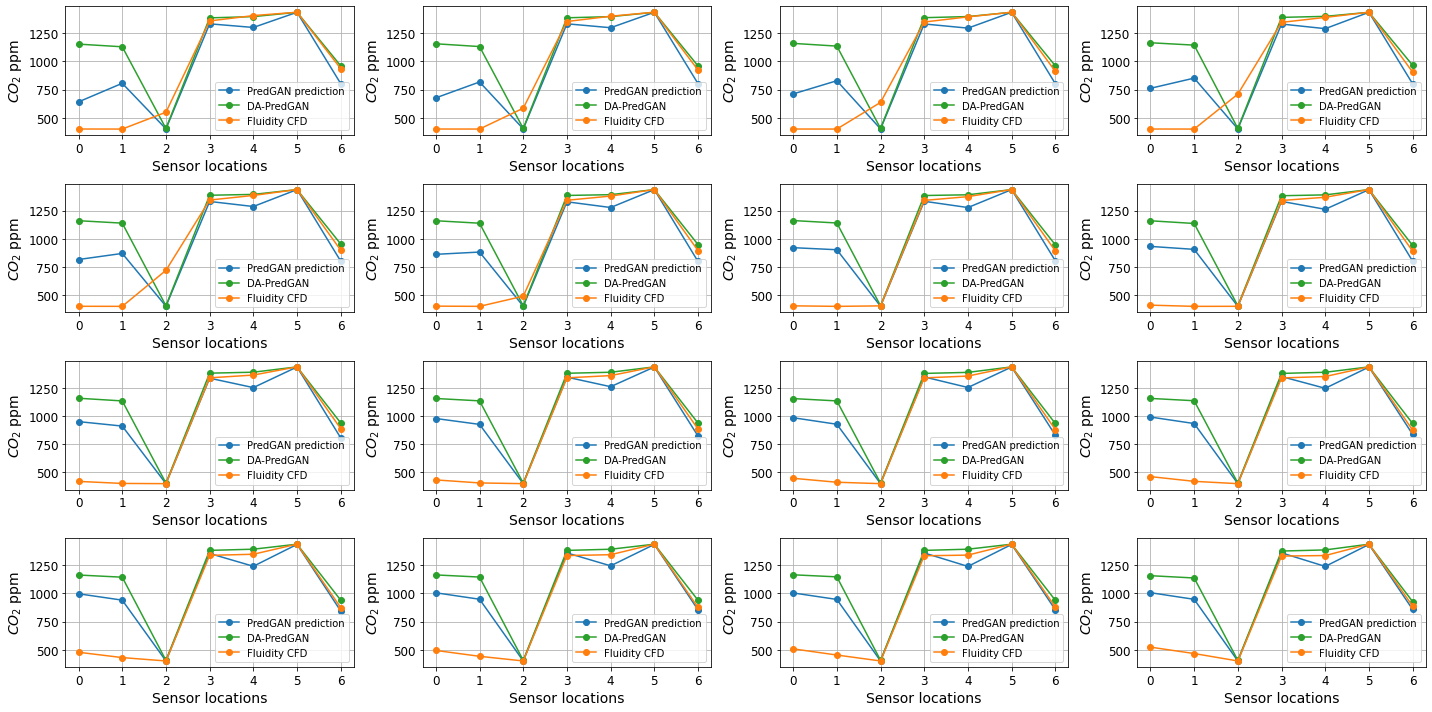

In [ ]:
fig, ax = plt.subplots(4,4, figsize=[20,10])
for i in range(16):
    ax.flatten()[i].plot(norm_sensor_CO2_[80+i, :], '-o', label='PredGAN prediction')
    ax.flatten()[i].plot(norm_sensor_CO2_DA[80+i, :], 'C2-o', label='DA-PredGAN')
    ax.flatten()[i].plot(CO2_sensor_all[80+i, :], 'C1-o', label='Fluidity CFD')
    ax.flatten()[i].legend()
    ax.flatten()[i].set_xlabel('Sensor locations')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].grid()

fig.tight_layout()

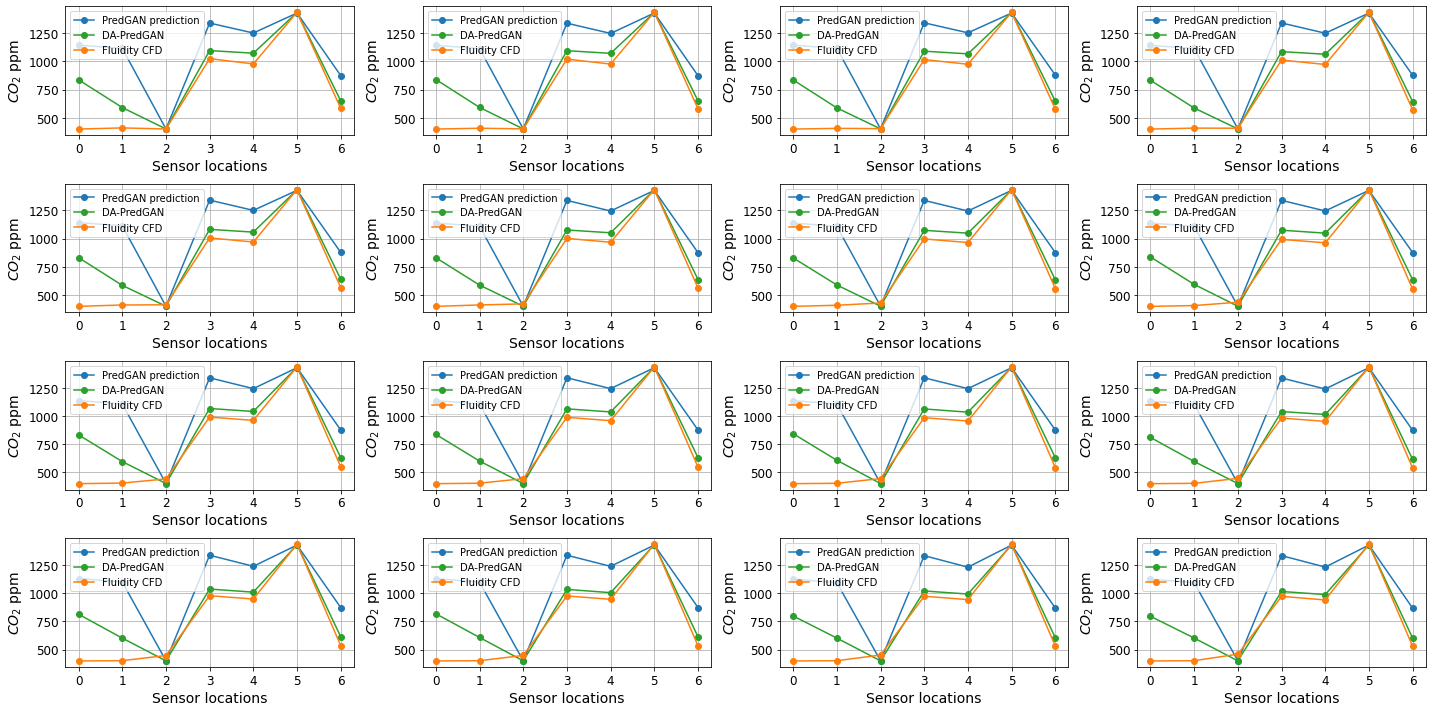

In [ ]:
fig, ax = plt.subplots(4,4, figsize=[20,10])
for i in range(16):
    ax.flatten()[i].plot(norm_sensor_CO2_[200+i, :], '-o', label='PredGAN prediction')
    ax.flatten()[i].plot(norm_sensor_CO2_DA[200+i, :], 'C2-o', label='DA-PredGAN')
    ax.flatten()[i].plot(CO2_sensor_all[200+i, :], 'C1-o', label='Fluidity CFD')
    ax.flatten()[i].legend()
    ax.flatten()[i].set_xlabel('Sensor locations')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].grid()

fig.tight_layout()

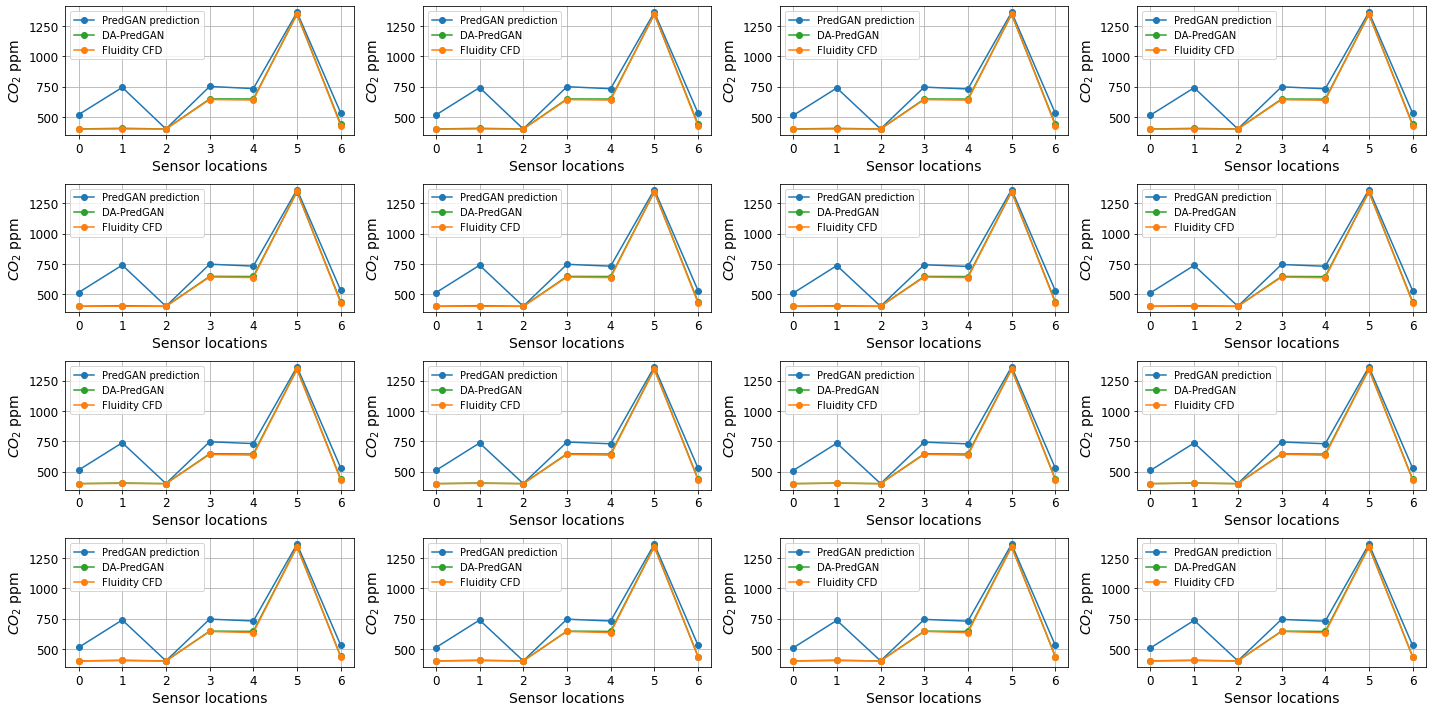

In [ ]:
fig, ax = plt.subplots(4,4, figsize=[20,10])
for i in range(16):
    ax.flatten()[i].plot(norm_sensor_CO2_[390+i, :], '-o', label='PredGAN prediction')
    ax.flatten()[i].plot(norm_sensor_CO2_DA[390+i, :], 'C2-o', label='DA-PredGAN')
    ax.flatten()[i].plot(CO2_sensor_all[390+i, :], 'C1-o', label='Fluidity CFD')
    ax.flatten()[i].legend()
    ax.flatten()[i].set_xlabel('Sensor locations')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].grid()

fig.tight_layout()

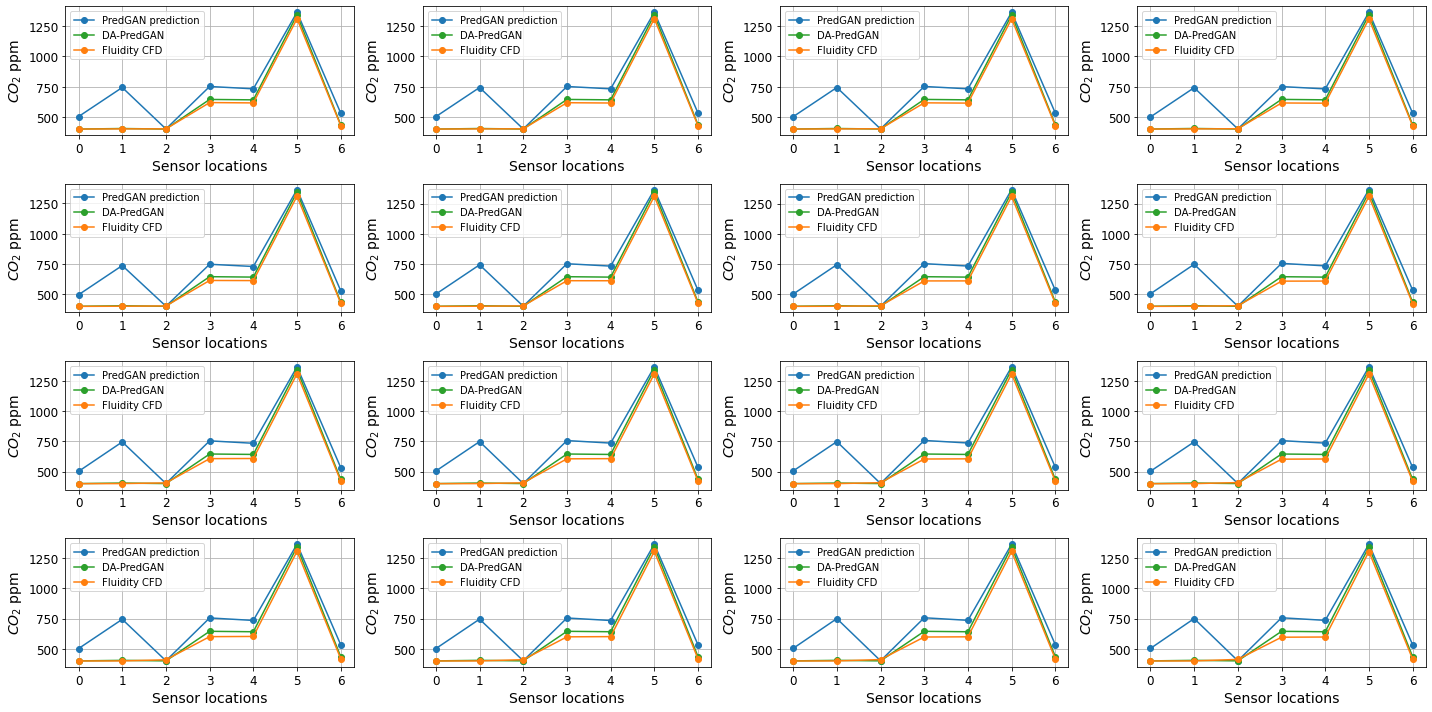

In [ ]:
fig, ax = plt.subplots(4,4, figsize=[20,10])
for i in range(16):
    ax.flatten()[i].plot(norm_sensor_CO2_[439+i, :], '-o', label='PredGAN prediction')
    ax.flatten()[i].plot(norm_sensor_CO2_DA[439+i, :], 'C2-o', label='DA-PredGAN')
    ax.flatten()[i].plot(CO2_sensor_all[439+i, :], 'C1-o', label='Fluidity CFD')
    ax.flatten()[i].legend()
    ax.flatten()[i].set_xlabel('Sensor locations')
    ax.flatten()[i].set_ylabel('$CO_{2}$ ppm')
    ax.flatten()[i].grid()

fig.tight_layout()

DA-PredGAN loss and relaxation graphs

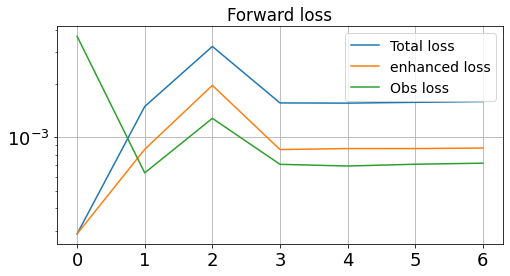

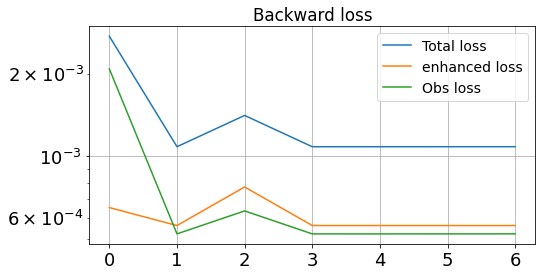

In [ ]:
# plotting loss function 
mpl.rcParams.update({'font.size': 14})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=18)

fig, ax = plt.subplots(1,1, figsize=[8,4])
ax.plot(forward_loss)
ax.set_title('Forward loss')
ax.set_yscale('log')
plt.grid()
plt.legend(['Total loss','enhanced loss','Obs loss'])    
fig, ax = plt.subplots(1,1, figsize=[8,4])
ax.plot(backward_loss)
ax.set_yscale('log')
ax.set_title('Backward loss')
plt.grid()
plt.legend(['Total loss','enhanced loss','Obs loss'])
fig.tight_layout()

0 [0.00150979 0.00046975 0.00288397]
1 [0.00128643 0.00070883 0.0005776 ]
2 [0.00128643 0.00070883 0.0005776 ]
3 [0.00128643 0.00070883 0.0005776 ]
4 [0.00128643 0.00070883 0.0005776 ]
5 [0.00128643 0.00070883 0.0005776 ]
6 [0.00128643 0.00070883 0.0005776 ]


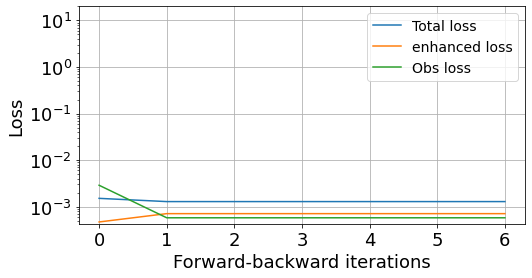

In [ ]:
loss = (np.array(backward_loss)+np.array(forward_loss))/2
new_loss = loss.copy()

# Because we discard the forward-backward iteration with loss greater than the minimum
print(0, new_loss[0,:])
for i in range(1,len(new_loss)):
    if new_loss[i,-1] > new_loss[i-1,-1]:
        new_loss[i,:] = new_loss[i-1,:] 
    print(i, new_loss[i,:])
    
fig, ax = plt.subplots(1,1, figsize=[8,4])
ax.plot(new_loss)
ax.set_yscale('log')
ax.set_ylim(top=2*10**1)
ax.set_ylabel('Loss') 
ax.set_xlabel('Forward-backward iterations')   
plt.grid()
plt.legend(['Total loss','enhanced loss','Obs loss'])

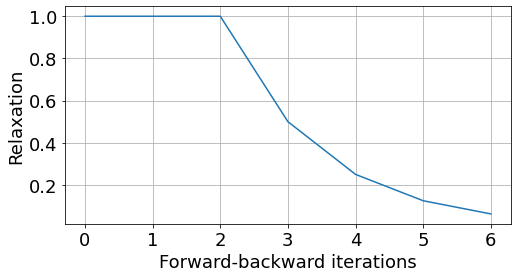

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[8,4])
ax.plot(list_relax)
ax.set_ylabel('Relaxation') 
ax.set_xlabel('Forward-backward iterations')   
plt.grid()